# Imports and defines

In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import cmocean as cmo
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

# from matplotlib import gridspec
# from matplotlib.gridspec import GridSpec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# import matplotlib.ticker as mticker
# import cartopy.mpl.ticker as cticker
# from cartopy.util import add_cyclic_point as cyclic
import cftime
# import nc_time_axis
import datetime

import xskillscore as xs

# # import time
# # import glob, os
# # import math
# import copy

# from sklearn.metrics import r2_score
# import scipy.interpolate as scp
# from scipy.stats import skew
from scipy.ndimage.filters import gaussian_filter

# import eofs
# from eofs.xarray import Eof

from matplotlib.patches import Ellipse


%load_ext autoreload
%autoreload 2

## Load functions from defs.py

In [2]:
from defs import change_lons, change_lons2, compute_SLP_eofs, varfs, EOF_analysis, set_background, lowess

# from defs import EOF_analysis, lowess, MT_spectrum, Confidence_intervals, change_lons, contourlines, 
# from defs import lat_ticks, lon_ticks, cyclic_array, varfs, compute_SLP_eofs, variance_bootstrap, 
# from defs import eofs_to_nc, varperc, calc_siva, scatter_hist, styles_width

from defs import select_month, SLP_indices, SST_indices, compute_gridweights, lead_lag_shifts, lead_lag_corr, create_index_map
from defs import select_winter, select_anomalies, compute_regression


## Definitions for data and figures

In [3]:
###########################################################
########## Some definitions for data and figures ##########
###########################################################

folder = 'PlioMIP2 data'
sim1 = "E280"; sim2 = "Eoi400"; sim3 = "Eoi280"; sim4 = "E400";
slp_name = "_slp_monthly.nc"
sst_name = "_sst_monthly.nc"
prect_name = "_prect_monthly.nc"

# slp_file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+slp_name
# sst_file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+sst_name

# .isel(time = ds.groupby("time.month").groups[1])

modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 
             'CESM2', 'COSMOS', 'EC-Earth3-LR', 'GISS2.1G',
             'HadCM3', 'HadGEM3', 'IPSL-CM5A', 'IPSL-CM5A2',
             'IPSL-CM6A', 'MIROC4m', 'MRI-GCGM2.3',
             'NorESM-L', 'NorESM1-F']

simlist = ["E280", "Eoi400"]

monthlist = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

markers = ['D', 'D', 'D', 's', 's', '<', '>', '*', 'P', 'P', 'o', 'o', 'o', '^', 'v', 'X', 'X']
msize   = [8,    8,   8,   8,   8,   9,   9,  13,  10,   10,   9,   9,   9,   9,   9,  10,  10]
colors  = ['w', 'k', 'w', 'w', 'k', 'w', 'w', 'w', 'w', 'k', 'w', 'k', 'w', 'w', 'w', 'w', 'k']
fillstyles = ['full', 'full', 'right', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 
              'full', 'right', 'full', 'full', 'full', 'full']

## sensitivity

modellist_sens = ["CCSM4-UoT", "CCSM4-Utr", "COSMOS", "HadCM3"]
simlist_sens = ["E280", "Eoi400", "Eoi280", "E400"]
idx_sens = np.array([1, 2, 5, 8])

markers_sens = ['D', 'o', '<', 'P']
msize_sens = [8, 9, 9, 10]


# # plot model values
# for i in range(len(modellist)):
#     ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
#             markeredgecolor ='k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

## define interpolation reference

In [4]:
# select interpolation reference
# model grid: CCSM4-Utrecht

i=2;
file = folder+"/"+modellist[i]+"/"+sim1+"/"+sim1+slp_name
dref  = xr.open_dataset(file).slp; 
interp_ref = dref.isel(time=0).drop("time")

## List of models to skip

In [5]:
# skip list:
#
# models to skip: 
# IPSLCM6A, MIROC4m, MRI2.3

idx = np.concatenate([np.arange(0,12), np.arange(15,17)])


***
***
***
***
***

# Load data 

## load data from other PlioMIP2 studies

In [6]:
# from Han et al 2021 CP
# got it from Zixuan
# https://doi.org/10.5194/cp-17-2537-2021 

# change in Pacific Walker circulation intensity (10^10 kg/s)
# annual mean data, Eoi400 - E280 
d_pwc_int = np.array([   2.4,    1.7,   4.2,    0.8,   -1.0, -0.3,  2.2, -1.5,  1.3, -0.3,
                      np.nan, np.nan,   0.0, np.nan, np.nan,  1.4,  1.6])

# change in Pacific Walker circulation center longitude (deg E)
# annual mean data, Eoi400 - E280 
d_pwc_lon = np.array([-9.0, -3.8, -16.9, -6.8, -2.9, 55.0, -10.9, 7.1, -14.0, -7.0, np.nan, 
                      np.nan, 0.2, np.nan, np.nan, -11.0, 5.0])


# from Pontes et al 2022 Nat Geo
# data via webplotdigitizer
# https://doi.org/10.1038/s41561-022-00999-y

# change in DJF West Pacific wind (%)
# DJF mean, Eoi400 - E280 / E280
d_djf_wpwind = np.array([28, 11, np.nan, np.nan, -3, -10, 32, -25, 5, np.nan, 3,
                         -3, 6, -4, -1, 16, 24])

# shift in DJF Pacific ITCZ (deg N)
# DJF mean, Eoi400 - E280
d_djf_pitcz = np.array([1.5, 2.7, np.nan, np.nan, -0.6, 2.1, 2.0, -1.6, 5.3, np.nan,
                       0.7, -0.3, 1.9, -1.5, 2.8, 4.9, 4.3])


# from Ren et al 2023 CP
# data via webplotdigitizer
# https://doi.org/10.5194/cp-19-2053-2023

# change in Maritime continent SSTs
# annual mean, Eoi400 - E280 
d_mc_sst = np.array([1.5, 2.1, 2.8, 2.5, 3.2, 1.9, 3.3, 1.0, 1.5, 3.3, 1.6, 1.4, 2.0, 1.9, 0.9, 0.6, 0.4])


# from de Nooijer et al 2020 CP

# January Arctic sea-ice extent change (d_jan_asie) in (%)
d_jan_asie = -1*np.array([34, 57, 50, 55, 76, 42, 57, 39, 38, np.nan, 32, 31, 38, 35, 21, 15, 23])

# Annual mean Arctic SAT anomaly with pre-ind (d_ann_sat) in (deg C)
d_ann_asat = np.array([6.8, 9.9, 10.5, 9.6, 10.8, 7.2, 11.6, 3.6, 5.1, np.nan, 5.0, 4.8, 7.0, 7.1, 7.4, 4.8, 5.1])

# from Weiffenbach et al 2023 CP

# AMOC strength change (Sv) (annual)
d_amoc = np.array([2.8, 0.8, 3.0, -0.6, 4.0, 3.4, 3.2, 8.1, 5.3, -1.9, 4.6, 5.9, 3.8, 0.5, np.nan, np.nan, 3.7])


#####

lit_ = xr.DataArray(data = d_pwc_int, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data = lit_.to_dataset(name = "d_pwc_int")
lit_data.d_pwc_int.attrs["units"] = "10^10 kg/s"
lit_data.d_pwc_int.attrs["description"] = "change in Pacific Walker circulation intensity"

lit_ = xr.DataArray(data = d_pwc_lon, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data["d_pwc_lon"] = lit_
lit_data.d_pwc_lon.attrs["units"] = "deg E"
lit_data.d_pwc_lon.attrs["description"] = "change in Pacific Walker circulation center longitude"

lit_ = xr.DataArray(data = d_djf_wpwind, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data["d_djf_wpwind"] = lit_
lit_data.d_djf_wpwind.attrs["units"] = "%"
lit_data.d_djf_wpwind.attrs["description"] = "change in DJF West Pacific wind"

lit_ = xr.DataArray(data = d_djf_pitcz, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data["d_djf_pitcz"] = lit_
lit_data.d_djf_pitcz.attrs["units"] = "deg N"
lit_data.d_djf_pitcz.attrs["description"] = "shift in DJF Pacific ITCZ"

lit_ = xr.DataArray(data = d_mc_sst, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data["d_mc_sst"] = lit_
lit_data.d_mc_sst.attrs["units"] = "deg C"
lit_data.d_mc_sst.attrs["description"] = "change in SST over Maritime continent"

lit_ = xr.DataArray(data = d_jan_asie, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data["d_jan_asie"] = lit_
lit_data.d_djf_pitcz.attrs["units"] = "%"
lit_data.d_djf_pitcz.attrs["description"] = "change in Jan Arctic sea-ice extent"

lit_ = xr.DataArray(data = d_ann_asat, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data["d_ann_asat"] = lit_
lit_data.d_mc_sst.attrs["units"] = "deg C"
lit_data.d_mc_sst.attrs["description"] = "change in annual Arctic Surface air temperature"

lit_ = xr.DataArray(data = d_amoc, dims = ["model"], coords=dict(model=("model", modellist)))
lit_data["d_amoc"] = lit_
lit_data.d_mc_sst.attrs["units"] = "Sv"
lit_data.d_mc_sst.attrs["description"] = "change in annual AMOC strength"

## ECS and ESS from Haywood et al. & Williams et al. (for HadGEM3)

ecs = np.array([3.2, 3.2, 3.2, 4.1, 5.3, 4.7, 4.3, 3.3, 3.5, 5.5, 4.1, 3.6, 4.8, 3.9, 2.8, 3.1, 2.3])
ecs = xr.DataArray(data=ecs, dims={"model"}, coords = {"model":modellist})

ess = np.array([5.1, 7.3, 9.1, 7.7, 10., 6.5, 9.4, 4.0, 5.6, 9.7, 4.5, 4.2, 6.5, 6.0, 4.7, 4.1, 3.3])
ess = xr.DataArray(data=ess, dims={"model"}, coords = {"model":modellist})

## Load NOAA observations

In [10]:
# Load observations

sst_obs = xr.open_dataset("Reanalysis/SST_ERSST_1916_2015_lowess.nc").SLP
slp_obs = xr.open_dataset("Reanalysis/SLP_CR20_1916_2015_lowess.nc").SLP
prect_obs = xr.open_dataset("Reanalysis/prect_CR20_1916_2015_lowess.nc").prect

***
***
***
***
***

# Computations and selections of data

## Select DJFM SLP SD in NP

### For PlioMIP2

In [12]:

# remove linear regression? (takes some extra time)
remove_regr = True;

# lat lon selection
dlat = 2; dlon = 2; #cutoff for set extent
# min_lat = 20-dlat; max_lat = 70+dlat; min_lon = 140-dlon; max_lon = 240+dlon; 
min_lat = 20-dlat; max_lat = 70+dlat; min_lon = 120-dlon; max_lon = 260+dlon; 

interp_ref_ = interp_ref.sel(lat = slice(min_lat - dlat, max_lat + dlat), lon = slice(min_lon - dlon, max_lon + dlon))

for j in range(len(simlist)):
    
    sim = simlist[j];

    for i in range(len(modellist)):

        # load model, select data
        model = modellist[i]
        file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+slp_name
        slp  = xr.open_dataset(file).slp; 
        
        # remove climatology, select DJFM
        slp = select_anomalies(slp, clim = True, regr = remove_regr)
        slp_djfm = select_winter(slp, 'DJFM')
        
        slp_sd = slp_djfm.std("time").sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
        slp_sd = slp_sd.interp_like(interp_ref).sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
        
        if i==0:
            slp_sd_ = slp_sd;
        else:
            slp_sd_ = xr.concat([slp_sd_, slp_sd], dim="model")
            
    if j==0:
        SLP_SD = slp_sd_
    else:
        SLP_SD = xr.concat([SLP_SD, slp_sd_], dim="sim")
        
SLP_SD["sim"] = simlist; SLP_SD["model"] = modellist;


### For NOAA data

In [13]:

# anomalies and select winter
slp = slp_obs.groupby('time.month') - slp_obs.groupby('time.month').mean('time')
slp_djfm = select_winter(slp, "DJFM")
        
slp_sd = slp_djfm.std("time").sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
slp_sd = slp_sd.interp_like(interp_ref).sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))

SLP_SD_obs = slp_sd


## Compute Nino and AL indices (monthly)

### For PlioMIP2

In [9]:

for i in range(len(modellist)):

    # E280
    sim = sim1
    
    sst_file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+sst_name
    sst = xr.open_dataset(sst_file)    
    nino1 = SST_indices(sst.sst, "Nino34", norm=False).drop("month"); 
        
    slp_file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+slp_name
    slp = xr.open_dataset(slp_file)    
    ali1  = SLP_indices(slp.slp, "ALI", norm=False).drop("month"); 
    
    # Eoi400
    sim = sim2
    
    sst_file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+sst_name
    sst = xr.open_dataset(sst_file)    
    nino2 = SST_indices(sst.sst, "Nino34", norm=False).drop("month"); 
        
    slp_file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+slp_name
    slp = xr.open_dataset(slp_file)    
    ali2  = SLP_indices(slp.slp, "ALI", norm=False).drop("month"); 
    
    # add timeseries
    if i==0:
        nino_pi = nino1; nino_plio = nino2;
        ali_pi  = ali1;  ali_plio  = ali2;
    else:
        nino_pi   = xr.concat([nino_pi,   nino1], dim="model");
        nino_plio = xr.concat([nino_plio, nino2], dim="model");
        ali_pi    = xr.concat([ali_pi,    ali1],  dim="model");
        ali_plio  = xr.concat([ali_plio,  ali2],  dim="model");
        
# make into 1 dataset
nino_ = nino_pi.expand_dims(dim = {"sim":1})
nino_ = xr.concat([nino_, nino_plio.expand_dims(dim = {"sim":1})], dim = "sim")
        
ali_  = ali_pi.expand_dims(dim = {"sim":1})
ali_  = xr.concat([ali_, ali_plio.expand_dims(dim = {"sim":1})],   dim = "sim")

ds = nino_.to_dataset(name = "nino")
ds["ali"] = ali_

ds = ds.assign_coords({"model": ("model", modellist)})
ds = ds.assign_coords({"sim": ("sim", simlist)})

ds.nino.attrs["units"] = 'deg C'
ds.nino.attrs["description"] = 'Nino3.4 index'
ds.ali.attrs["units"] = 'hPa'
ds.ali.attrs["description"] = 'Aleutian low index'


### Save:

In [10]:
ds.to_netcdf('PlioMIP2 data/PlioMIP2_NINO_ALI_indices.nc', mode='w')

In [7]:
ds = xr.open_dataset('PlioMIP2 data/PlioMIP2_NINO_ALI_indices.nc')


## Select DJF Nino and DJFM AL

In [8]:


ds = xr.open_dataset('PlioMIP2 data/PlioMIP2_NINO_ALI_indices.nc')

for j in range(len(simlist)):
    
    sim = simlist[j];

    for i in range(len(modellist)):

        model = modellist[i]
        file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+slp_name

        nino = ds.nino.isel(model=i).sel(sim=sim)
        ali  = ds.ali.isel(model=i).sel(sim=sim)

        # Select DJF Nino and DJFM ALi
        nino_djf = select_winter(nino, "DJF")
        ali_djfm = select_winter(ali, "DJFM")

        if i==0:
            NINO = nino_djf; ALI = ali_djfm;
        else:
            NINO = xr.concat([NINO, nino_djf], dim="model");
            ALI = xr.concat([ALI, ali_djfm], dim="model");
        
    if j==0: 
        NINO1 = NINO; ALI1 = ALI;
    else:
        NINO_ = xr.concat([NINO1, NINO], dim="sim");
        ALI_ = xr.concat([ALI1, ALI], dim="sim");
    
nino_djf = NINO_
ali_djfm = ALI_

### NOAA indices:

In [11]:

nino_obs = SST_indices(sst_obs, "Nino34", norm=False)
ali_obs  = SLP_indices(slp_obs, "ALI", norm=False)

nino_obs_djf = select_winter(nino_obs, "DJF")
ali_obs_djfm = select_winter(ali_obs, "DJFM")

## Linear regression

### PlioMIP2

In [21]:

linslope = np.zeros((len(modellist),2))

for j in range(len(simlist)):
    
    sim = simlist[j]

    for i in range(len(modellist)):

        x = nino_djf.sel(model = modellist[i]).sel(sim = sim)
        y = ali_djfm.sel(model = modellist[i]).sel(sim = sim)

        linslope[i,j] = xs.linslope(x, y, dim='time').values
        
        # check if p<0.05 and corr<0
        # if not: set slope to zero (no regression)
        pval = xs.pearson_r_p_value(x, y, dim='time').values
        corr = xs.pearson_r(x, y, dim='time').values
        
        if pval>0.05 or corr>0:
            linslope[i,j] = 0.;

linslope = xr.DataArray(data = linslope, dims = ["model", "sim"], coords=dict(model=("model", modellist), sim=("sim", simlist)))
linslope.attrs["unit"] = "hPa per deg C"

### NOAA

In [22]:

x = nino_obs_djf
y = ali_obs_djfm

linslope_obs = xs.linslope(x, y, dim='time').values


## calculate WEP precip

In [23]:

remove_clim = False
remove_regr = False

for i in range(len(modellist)):

    # E280
    sim = sim1
    
    file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+prect_name
    prect = xr.open_dataset(file).prect
    
    prect_wep = prect.sel(lat=slice(-6,6), lon=slice(140,180)).mean({"lon", "lat"})
#     prect_wep = prect.sel(lat=slice(-6,6), lon=slice(120,180)).mean({"lon", "lat"})
    prect_wep1 = select_anomalies(prect_wep, clim = remove_clim, regr = remove_regr)
    
    # Eoi400
    sim = sim2
    
    file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+prect_name
    prect = xr.open_dataset(file).prect
    
    prect_wep = prect.sel(lat=slice(-6,6), lon=slice(140,180)).mean({"lon", "lat"})
#     prect_wep = prect.sel(lat=slice(-6,6), lon=slice(120,180)).mean({"lon", "lat"})
    prect_wep2 = select_anomalies(prect_wep, clim = remove_clim, regr = remove_regr)
    
    # add timeseries
    if i==0:
        pw1 = prect_wep1; pw2 = prect_wep2;
    else:
        pw1 = xr.concat([pw1, prect_wep1], dim="model");
        pw2 = xr.concat([pw2, prect_wep2], dim="model");

# make into 1 dataset
pw_ = pw1.expand_dims(dim = {"sim":1})
pw_ = xr.concat([pw_, pw2.expand_dims(dim = {"sim":1})], dim = "sim")

ds = pw_.to_dataset(name = "pr_wep")
ds = ds.assign_coords({"model": ("model", modellist)})
ds = ds.assign_coords({"sim": ("sim", simlist)})

ds.pr_wep.attrs["units"] = 'mm/day'
ds.pr_wep.attrs["description"] = 'West Equatorial Pacific precipitation'

pr_wep = ds.pr_wep


### select DJF wep_precip

In [24]:
prwep_djf = select_winter(pr_wep, "DJF")




### For NOAA

In [25]:
prect_wep_obs = prect_obs.sel(lat=slice(-6,6), lon=slice(140,180)).mean({"lon", "lat"})
prwep_djf_obs = select_winter(prect_wep_obs, "DJF")


## Compute Nino - precip / WEP pr - SLP regressions

In [34]:

index = nino_djf;
variable = "prect"

for j in range(len(simlist)):
    
    sim = simlist[j];

    for i in range(len(modellist)):
        model = modellist[i]

        # load data
        file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+prect_name
        data  = xr.open_dataset(file).prect; 

        # remove climatology and select DJF
        data_a = select_anomalies(data, clim = True, regr = False)
        data_a = select_winter(data_a, mode="DJF");

        # you can select a region here
        data_a          = data_a.sel(lat=slice(-25, 25), lon=slice(110, 280))
        interp_ref_ = interp_ref.sel(lat=slice(-20, 20), lon=slice(115, 275))

        # select index
        index_ = index.isel(model=i).sel(sim=sim)
        
        # get regression, correlation, pval
        stat = compute_regression(index_, data_a, dim = "time")
        stat = stat.interp_like(interp_ref)

        if i==0: stat_ = stat
        else: stat_ = xr.concat([stat_, stat], dim='model')
            
    if j==0: stat__ = stat_
    else: stat__ = xr.concat([stat__, stat_], dim='sim')
        
nino_prect_regr = stat__


In [35]:

index = prwep_djf;
variable = "slp"

for j in range(len(simlist)):
    
    sim = simlist[j];

    for i in range(len(modellist)):
        model = modellist[i]

        # load data
        file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+slp_name
        data  = xr.open_dataset(file).slp; 

        # remove climatology and select DJF(M)
        data_a = select_anomalies(data, clim = True, regr = False)
        data_a = select_winter(data_a, mode="DJFM");

        # you can select a region here
        data_a          = data_a.sel(lat=slice(25, 75), lon=slice(110, 280))
        interp_ref_ = interp_ref.sel(lat=slice(30, 70), lon=slice(115, 275))

        # select index
        index_ = index.isel(model=i).sel(sim=sim)
        
        # get regression, correlation, pval
        stat = compute_regression(index_, data_a, dim = "time")
        stat = stat.interp_like(interp_ref)

        if i==0: stat_ = stat
        else: stat_ = xr.concat([stat_, stat], dim='model')
            
    if j==0: stat__ = stat_
    else: stat__ = xr.concat([stat__, stat_], dim='sim')
        
prwep_slp_regr = stat__


### For NOAA

In [27]:
index = nino_obs_djf
data = prect_obs

data_a = select_winter(data, mode="DJF")
data_a = data_a.sel(lat=slice(-25, 25), lon=slice(110, 280))

nino_prect_regr_obs = compute_regression(index, data_a, dim="time")

###

index = prwep_djf_obs
data = slp_obs

data_a = select_winter(data, mode="DJFM")
data_a = data_a.sel(lat=slice(25, 75), lon=slice(110, 280))

prwep_slp_regr_obs = compute_regression(index, data_a, dim="time")

## Linear regression model: AL variability with ENSO regression

In [38]:
# Select model and simulations

da_1 = 0. * ali_djfm;
da_2 = 0. * ali_djfm;

for j in range(len(simlist)):
    
    sim = simlist[j]

    for i in range(len(modellist)):

        model = modellist[i]

        nino = nino_djf.sel(sim=sim).sel(model=model)
        ali  = ali_djfm.sel(sim=sim).sel(model=model)
        
        # split following linear regression model
        regr = compute_regression(nino, ali, dim = "time")
        if regr.pval < 0.05:
            ali_nino = regr.regr * nino;
        else:
            ali_nino = 0. * nino;
            
        ali_res = ali - ali_nino; 
        
        da_1[j,i,:] = ali_nino;
        da_2[j,i,:] = ali_res;
               
da = da_1.to_dataset(name = "nino")
da["res"] = da_2

da.nino.attrs["units"] = 'hPa'
da.nino.attrs["description"] = 'ALI regressing with DJF Nino'
da.res.attrs["units"] = 'hPa'
da.res.attrs["description"] = 'ALI residual (minus Nino part)'
da.attrs["description"] = 'DJFM ALI split in Nino regressing and residual'

# save ALI LRM = linear regression model
ali_lrm = da;

In [1214]:
# for NOAA

nino = nino_obs_djf;
ali  = ali_obs_djfm;

# split following linear regression model
regr = compute_regression(nino, ali, dim = "time")
ali_nino = regr.regr * nino;
ali_res = ali - ali_nino; 

da = ali_nino.to_dataset(name = "nino")
da["res"] = ali_res

da.nino.attrs["units"] = 'hPa'
da.nino.attrs["description"] = 'ALI regressing with DJF Nino'
da.res.attrs["units"] = 'hPa'
da.res.attrs["description"] = 'ALI residual (minus Nino part)'
da.attrs["description"] = 'DJFM ALI split in Nino regressing and residual'

# save ALI LRM = linear regression model
ali_lrm_obs = da;

## Compute NINO and ALI from Eoi280 and E400 sensitivity studies

In [18]:
# NINO and ALI indices from Eoi280

ds = xr.open_dataset('PlioMIP2 data/PlioMIP2_NINO_ALI_indices.nc')

for i in range(len(modellist_sens)):

    index12 = ds.sel(model=modellist_sens[i])

    # Eoi280
    
    sim = sim3
    if i != 0:
        sst_file = folder+"/"+modellist_sens[i]+"/"+sim+"/"+sim+sst_name
        sst      = xr.open_dataset(sst_file)    
        nino1    = SST_indices(sst.sst, "Nino34", norm=False).drop("month"); 
        nino_    = nino1.expand_dims(dim = {"sim":1})
        nino_    = nino_.assign_coords({"sim": ("sim", [sim])})

        slp_file = folder+"/"+modellist_sens[i]+"/"+sim+"/"+sim+slp_name
        slp      = xr.open_dataset(slp_file)    
        ali1     = SLP_indices(slp.slp, "ALI", norm=False).drop("month"); 
        ali_     = ali1.expand_dims(dim = {"sim":1})
        ali_     = ali_.assign_coords({"sim": ("sim", [sim])})
    else:
        nino_    = np.nan*index12.sel(sim=sim1).nino
        nino_["sim"] = sim
        ali_    = np.nan*index12.sel(sim=sim1).ali
        ali_["sim"] = sim
    
    nino123  = xr.concat([index12.nino, nino_], dim = "sim")
    ali123   = xr.concat([index12.ali, ali_], dim = "sim")
    
    # E400
    
    sim = sim4
    if i != 1:
        sst_file = folder+"/"+modellist_sens[i]+"/"+sim+"/"+sim+sst_name
        sst      = xr.open_dataset(sst_file)    
        nino1    = SST_indices(sst.sst, "Nino34", norm=False).drop("month"); 
        nino_    = nino1.expand_dims(dim = {"sim":1})
        nino_    = nino_.assign_coords({"sim": ("sim", [sim])})

        slp_file = folder+"/"+modellist_sens[i]+"/"+sim+"/"+sim+slp_name
        slp      = xr.open_dataset(slp_file)    
        ali1     = SLP_indices(slp.slp, "ALI", norm=False).drop("month"); 
        ali_     = ali1.expand_dims(dim = {"sim":1})
        ali_     = ali_.assign_coords({"sim": ("sim", [sim])})
    else:
        nino_    = np.nan*index12.sel(sim=sim1).nino
        nino_["sim"] = sim
        ali_    = np.nan*index12.sel(sim=sim1).ali
        ali_["sim"] = sim
    
    nino1234  = xr.concat([nino123, nino_], dim = "sim")
    ali1234   = xr.concat([ali123, ali_], dim = "sim")

    if i == 0:
        nino_sens = nino1234; ali_sens = ali1234;
    else:
        nino_sens = xr.concat([nino_sens, nino1234], dim="model")
        ali_sens  = xr.concat([ali_sens,  ali1234],  dim="model")

### select DJF(M)

In [25]:
nino_sens_djf = select_winter(nino_sens, "DJF")
ali_sens_djfm = select_winter(ali_sens, "DJFM")

### Compute amplitude

In [26]:
nino_sd = nino_sens_djf.std("time")
ali_sd  = ali_sens_djfm.std("time")

## Compute ENSO change - AL change distance and fraction of response

In [143]:
x1 = nino_sd.sel(sim=sim1); x2 = nino_sd.sel(sim=sim2); x3 = nino_sd.sel(sim=sim3); x4 = nino_sd.sel(sim=sim4);
y1 = ali_sd.sel(sim=sim1);  y2 = ali_sd.sel(sim=sim2);  y3 = ali_sd.sel(sim=sim3); y4 = ali_sd.sel(sim=sim4);


# Using Eoi280

# distance Pliocene BCs
dnino_bc = 100*(x2-x1)/x1 - 100*(x3-x1)/x1
dali_bc  = 100*(y2-y1)/y1 - 100*(y3-y1)/y1
D3_bc  = np.sqrt( (dnino_bc)**2  + (dali_bc)**2 )

# distance CO2
dnino_co2 = 100*(x2-x1)/x1 - 100*(x2-x3)/x3
dali_co2  = 100*(y2-y1)/y1 - 100*(y2-y3)/y3
D3_co2  = np.sqrt( (dnino_co2)**2  + (dali_co2)**2 )

# Using E400

# distance Pliocene BCs
dnino_bc = 100*(x2-x1)/x1 - 100*(x2-x4)/x4
dali_bc  = 100*(y2-y1)/y1 - 100*(y2-y4)/y4
D4_bc  = np.sqrt( (dnino_bc)**2  + (dali_bc)**2 )

# distance CO2
dnino_co2 = 100*(x2-x1)/x1 - 100*(x4-x1)/x1
dali_co2  = 100*(y2-y1)/y1 - 100*(y4-y1)/y1
D4_co2  = np.sqrt( (dnino_co2)**2  + (dali_co2)**2 )

# compute fraction of response
f4_bcs = D4_bc/(D4_co2+D4_bc)
f3_bcs = D3_bc/(D3_co2+D3_bc)

In [65]:

model = 'COSMOS'
sim='E280'
sst_file = folder+"/"+model+"/"+sim+"/"+sim+sst_name
sst      = xr.open_dataset(sst_file).sst.isel(time=0)

In [66]:
gw1 = compute_gridweights(sst)

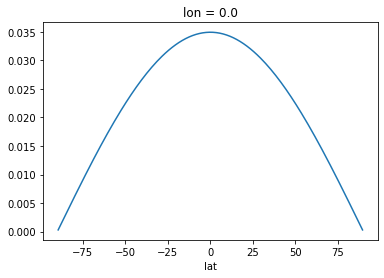

In [67]:
gw1.isel(lon=0).plot()

In [68]:
gw2 = np.cos(np.deg2rad(sst.lat))

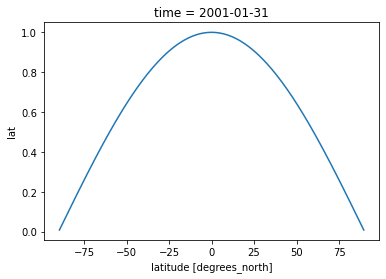

In [69]:
gw2.plot()

***
***
***
***
***

# Plot figures

# Plot: DJFM SLP SD in NP

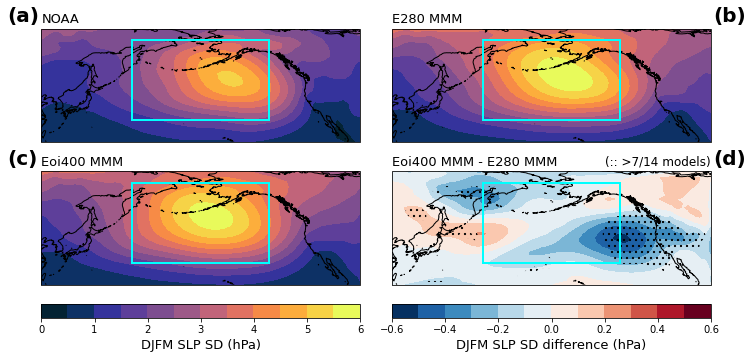

In [1364]:
levels1 = np.arange(0,6.5,0.5)
levels2 = np.arange(-0.6, 0.7, 0.1)
cmap1 = plt.get_cmap('cmo.thermal');
cmap2 = plt.cm.RdBu_r

fig = plt.figure(figsize=(12,5.5))
clon=-105

widths = [1, 1]; heights = [1, 1, 0.1];
spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

x = SLP_SD.sel(sim=sim1).isel(model=idx)#.mean("model")
y = SLP_SD.sel(sim=sim2).isel(model=idx)#.mean("model")
counts = xr.where((y-x)<0, -1, 1)

ax = fig.add_subplot(spec[0,0], projection=ccrs.PlateCarree(central_longitude=clon))
SLP_SD_obs.plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title("NOAA", loc="left", fontsize=13)

ax.text(-150, 73, '(a)', fontsize = 20, fontweight = 'bold')

ax = fig.add_subplot(spec[0,1], projection=ccrs.PlateCarree(central_longitude=clon))
x.mean("model").plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title("E280 MMM", loc="left", fontsize=13)

ax.text(6, 73, '(b)', fontsize = 20, fontweight = 'bold')

ax = fig.add_subplot(spec[1,0], projection=ccrs.PlateCarree(central_longitude=clon))
y.mean("model").plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title("Eoi400 MMM", loc="left", fontsize=13)

ax.text(-150, 73, '(c)', fontsize = 20, fontweight = 'bold')

ax = fig.add_subplot(spec[2,0])
norm = matplotlib.colors.BoundaryNorm(levels1, cmap1.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1, norm=norm, orientation='horizontal'); 
cbar.set_label(f'DJFM SLP SD (hPa)', fontsize=13); 

ax = fig.add_subplot(spec[1,1], projection=ccrs.PlateCarree(central_longitude=clon))
(y.mean("model")-x.mean("model")).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap2, levels=levels2, add_colorbar =False)
(counts.sum("model").where(np.abs(counts.sum("model"))>6)).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), hatches = ['..'], colors='None', add_colorbar=False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title("Eoi400 MMM - E280 MMM", loc="left", fontsize=13); ax.set_title("(:: >7/14 models)", loc="right")

ax.text(6, 73, '(d)', fontsize = 20, fontweight = 'bold')

ax = fig.add_subplot(spec[2,1])
norm = matplotlib.colors.BoundaryNorm(levels2, cmap2.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap2, norm=norm, orientation='horizontal'); 
cbar.set_label(f'DJFM SLP SD difference (hPa)', fontsize=13); 

# plt.savefig('figures/paper/Figure1.png', dpi=300)


## Plot Nino_djf and ALI_djfm and change

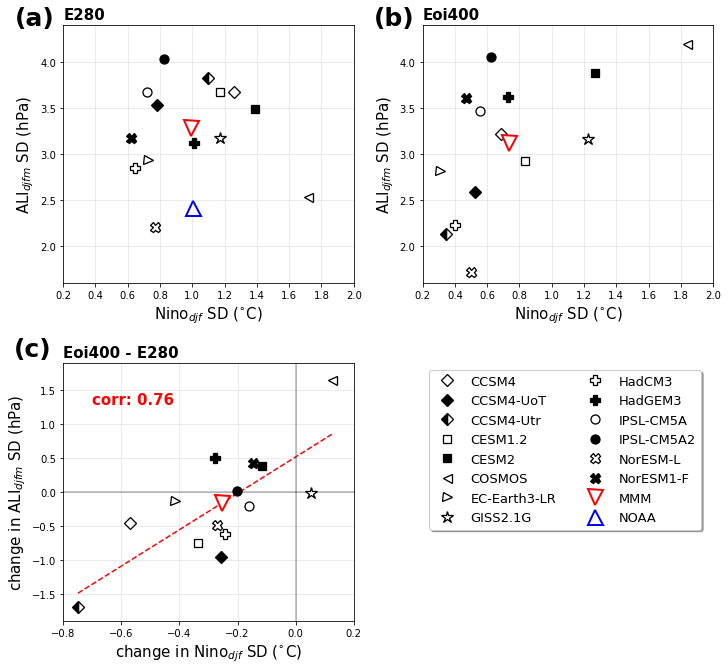

In [14]:
fig = plt.figure(figsize=(10,9.2), constrained_layout=True)
widths = [1, 1]; heights = [1, 1];
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [0.2, 2.0]; ylims = [1.6, 4.4];

ax = fig.add_subplot(spec[0])

x = nino_djf.sel(sim=sim1).std("time")
y = ali_djfm.sel(sim=sim1).std("time")

x_obs = nino_obs_djf.std("time")
y_obs = ali_obs_djfm.std("time")

ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')
ax.plot(x_obs, y_obs, marker = '^', color='w', markeredgecolor='blue', markeredgewidth=2, linestyle = 'None', markersize = 15, label = 'NOAA')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'ALI$_{djfm}$ SD (hPa)', fontsize=15)
ax.set_title("E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

ax.text(-0.1, 4.4, '(a)', fontsize = 25, fontweight='bold')

#############################################################

ax = fig.add_subplot(spec[1])

x = nino_djf.sel(sim=sim2).std("time")
y = ali_djfm.sel(sim=sim2).std("time")

ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel('Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel('ALI$_{djfm}$ SD (hPa)', fontsize=15)
ax.set_title("Eoi400", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

ax.text(-0.1, 4.4, '(b)', fontsize = 25, fontweight='bold')

#############################################################

xlims = [-0.8, 0.2]; ylims = [-1.9, 1.9];

ax = fig.add_subplot(spec[2])

x = nino_djf.sel(sim=sim2).std("time") - nino_djf.sel(sim=sim1).std("time")
y = ali_djfm.sel(sim=sim2).std("time") - ali_djfm.sel(sim=sim1).std("time")

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')
ax.set_xlabel('change in Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel('change in ALI$_{djfm}$ SD (hPa)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

x = x.isel(model=idx); y = y.isel(model=idx);
polyfit = np.polyfit(x,y,deg=1)
x_ = np.array([x.min(), x.max()]);
y_ = np.polyval(polyfit, x_)
ax.plot(x_, y_, 'r--',zorder=-1)

corr =  xs.pearson_r(x, y, dim='model').values
ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

ax.text(-0.97, 2., '(c)', fontsize = 25, fontweight='bold')

ax = fig.add_subplot(spec[3])
ax.legend(h,l, loc='upper left', shadow=True, ncol=2, fontsize=13)
ax.set_axis_off()


# plt.savefig('figures/paper/Figure2.png',dpi=300)


## Plot linear slopes

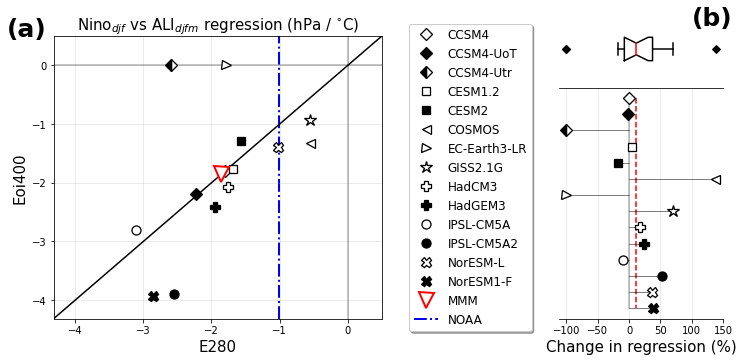

In [31]:

fig = plt.figure(figsize=(12,5.2))

widths = [1, .3, .5]; heights = [.1, .9];
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths, height_ratios=heights)

#############################

x = linslope.sel(sim=sim1)
y = linslope.sel(sim=sim2)

ax = fig.add_subplot(spec[:,0])

d_ax=1.1; d_zero = 0.5;
ax.plot([d_ax*np.min([x,y]), d_ax*np.max([x,y])+d_zero], [d_ax*np.min([x,y]), d_ax*np.max([x,y])+d_zero], 'k-')
ax.set_xlim([d_ax*np.min([x,y]), d_ax*np.max([x,y])+d_zero])
ax.set_ylim([d_ax*np.min([x,y]), d_ax*np.max([x,y])+d_zero])
ax.grid(alpha=0.3)
ax.plot([0,0], [d_ax*np.min([x,y]), d_ax*np.max([x,y])+d_zero], 'k-', alpha=0.3)
ax.plot([d_ax*np.min([x,y]), d_ax*np.max([x,y])+d_zero], [0,0], 'k-', alpha=0.3)

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                    markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x[idx].mean(), y[idx].mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')

ax.plot([linslope_obs, linslope_obs], [d_ax*np.min([x,y]), d_ax*np.max([x,y])+d_zero], 'b-.', linewidth=2, label='NOAA', zorder=-1)

# ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1.), shadow=True, ncol=1, fontsize=12)
ax.set_xlabel('E280', fontsize = 15)
ax.set_ylabel('Eoi400', fontsize = 15)
ax.set_title(r'Nino$_{djf}$ vs ALI$_{djfm}$ regression (hPa / $^{\circ}$C)', fontsize = 15)

ax.text(-5, 0.5, '(a)', fontsize = 25, fontweight='bold')

h, l = ax.get_legend_handles_labels() 

ax = fig.add_subplot(spec[:,1])
ax.legend(h,l, loc='center', shadow=True, ncol=1, fontsize=12)
ax.set_axis_off()

######################################

x = 100*(linslope.sel(sim=sim2) - linslope.sel(sim=sim1))/linslope.sel(sim=sim1)
y = np.arange(len(idx))

ax = fig.add_subplot(spec[1,2])

ax.plot([0,0], [y.min(), y.max()], 'k-', alpha=0.3)

for j in range(len(idx)):
    i = idx[j]
    ax.plot([0, x[i]], [y[j], y[j]], 'k-', linewidth = 0.5)
    ax.plot(x[i], y[j], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                    markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot([x[idx].mean(),x[idx].mean()] , [y.min(), y.max()], color='r', linestyle='--', label='MMM',zorder=-1)
    
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)    
ax.invert_yaxis()

ax.set_xticks([-100,-50,0,50,100,150])
# ax.xaxis.tick_top()
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel(r'Change in regression (%)', fontsize = 15)
# ax.xaxis.set_label_position('top') 
ax.grid(alpha=0.3)

######################################

ax = fig.add_subplot(spec[0,2])

bp = ax.boxplot(x.values[idx], notch=True, vert=0, widths = 3,
               boxprops=dict(linewidth=1.5), capprops=dict(linewidth=1.5), whiskerprops=dict(linewidth=1.5),
               flierprops=dict(markerfacecolor='k', marker='D'),
               medianprops=dict(linewidth=1.5, color='r'));
ax.set_axis_off()

ax.text(100, 4, '(b)', fontsize = 25, fontweight='bold')

plt.savefig('figures/paper/Figure3.png', dpi=300)

## Plot SST - precip - SLP regressions

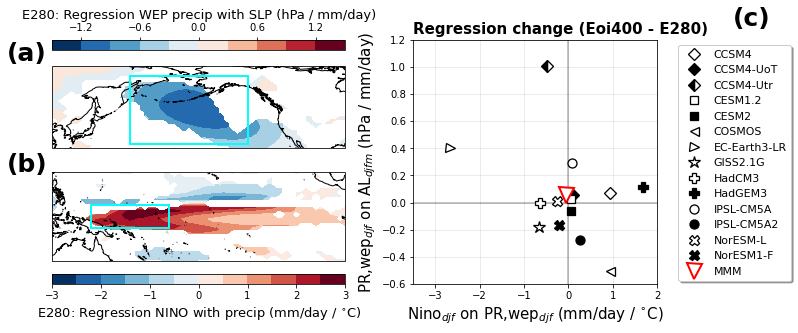

In [37]:

fig = plt.figure(figsize=(12,4.5))
# clon=-105
clon=180

widths = [1.2, 0.15, 1, 0.2]; heights = [0.1, 1, 1, 0.1];
spec = fig.add_gridspec(ncols=4, nrows=4, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

regr_unit = 'hPa / mm/day'
levels1 = np.arange(-1.5, 1.5+0.3, 0.3)
x = prwep_slp_regr.isel(model=idx).sel(sim=sim1)
counts = xr.where((x.pval)<0.05, -1, 1)

cmap=plt.cm.RdBu_r
ax = fig.add_subplot(spec[1,0], projection=ccrs.PlateCarree(central_longitude=clon))
x.regr.mean("model").where(np.abs(counts.sum("model"))>6).plot.contourf(ax=ax, levels = levels1, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(); 
ax.set_extent([120, 270, 28, 70], crs=ccrs.PlateCarree())
ax.set_title('')

ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', lw=2, transform=ccrs.PlateCarree(), zorder=2))

ax.text(-83, 73, '(a)', fontsize = 25, fontweight = 'bold')

ax = fig.add_subplot(spec[0,0])
norm = matplotlib.colors.BoundaryNorm(levels1, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal'); 
ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
cbar.set_label(f'E280: Regression WEP precip with SLP ({regr_unit})', fontsize=13); 


####################################################################

regr_unit = r'mm/day / $^{\circ}$C'
levels2 = np.arange(-3, 3+0.5, 0.5)
x = nino_prect_regr.isel(model=idx).sel(sim=sim1)
counts = xr.where((x.pval)<0.05, -1, 1)

ax = fig.add_subplot(spec[2,0], projection=ccrs.PlateCarree(central_longitude=clon))
x.regr.mean("model").where(np.abs(counts.sum("model"))>6).plot.contourf(ax=ax, levels = levels2, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(); 
ax.set_extent([120, 270, -23, 23], crs=ccrs.PlateCarree())
ax.set_title('')

ax.add_patch(Rectangle((140,-6),40,12, edgecolor='cyan', facecolor='none', lw = 2, transform=ccrs.PlateCarree(), zorder=2))

ax.text(-83, 23, '(b)', fontsize = 25, fontweight = 'bold')

ax = fig.add_subplot(spec[3,0])
norm = matplotlib.colors.BoundaryNorm(levels2, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal'); 
cbar.set_label(f'E280: Regression NINO with precip ({regr_unit})', fontsize=13); 

#############################################################

# xlims = [-2, 2]; ylims = [-2, 2];
xlims = [-3.5, 2.0]; ylims = [-0.6, 1.2];

ax = fig.add_subplot(spec[:,2])

x1 = compute_regression(nino_djf.sel(sim=sim1), prwep_djf.sel(sim=sim1))
x2 = compute_regression(nino_djf.sel(sim=sim2), prwep_djf.sel(sim=sim2))
y1 = compute_regression(prwep_djf.sel(sim=sim1), ali_djfm.sel(sim=sim1))
y2 = compute_regression(prwep_djf.sel(sim=sim2), ali_djfm.sel(sim=sim2))

x = x2.regr.where(x2.pval<0.05, 0) - x1.regr.where(x1.pval<0.05, 0)
y = y2.regr.where(y2.pval<0.05, 0) - y1.regr.where(y1.pval<0.05, 0)

# x = prwep_djf.sel(sim=sim2).std("time") - prwep_djf.sel(sim=sim1).std("time")
# y = ali_djfm.sel(sim=sim2).std("time") - ali_djfm.sel(sim=sim1).std("time")

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')

# ax.set_xlabel('PR,wep$_{djf}$ SD (mm/day)', fontsize=15);
# ax.set_ylabel('ALI$_{djfm}$ SD (hPa)', fontsize=15)
ax.set_xlabel(r'Nino$_{djf}$ on PR,wep$_{djf}$ (mm/day / $^{\circ}$C)', fontsize=15);
ax.set_ylabel('PR,wep$_{djf}$ on AL$_{djfm}$ (hPa / mm/day)', fontsize=15)
ax.set_title("Regression change (Eoi400 - E280)", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

h, l = ax.get_legend_handles_labels() 

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-1.4, 1.2, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

ax.text(3.7, 1.3, '(c)', fontsize = 25, fontweight='bold')

#############################################################

ax = fig.add_subplot(spec[:,3])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=11)
ax.set_axis_off()


plt.savefig('figures/paper/Figure4.png', dpi=300)

# plt.suptitle('hallo')

## Plot LRM bar graph

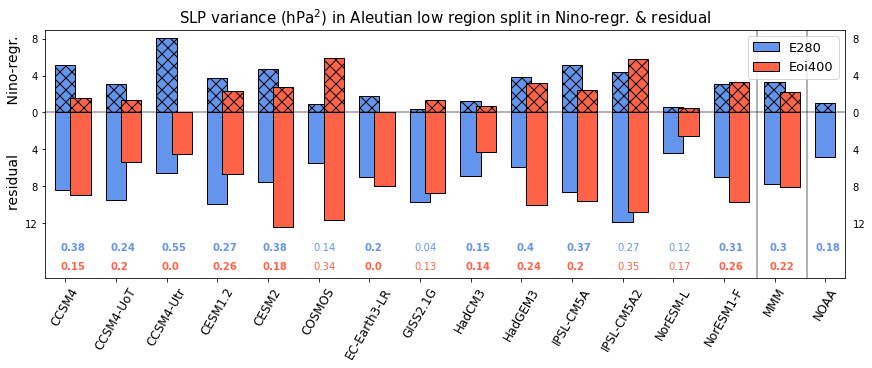

In [1336]:

col1 = 'cornflowerblue'
col2 = 'tomato'

width = 0.4 

ind = np.arange(len(idx))

# graph
    
fig = plt.figure(figsize =(12, 5), constrained_layout = True)
ax = fig.add_subplot(111)

ax.set_xticks(np.arange(len(ind)+2))
ax.set_xticklabels(np.concatenate([np.array(modellist)[idx],np.array(['MMM']),np.array(['NOAA'])]))
ax.tick_params(axis='x', labelsize=12, rotation=60); ax.tick_params(axis='y', labelright=True);

ax.plot([ind.min()-.4, ind.max()+2.4], [0,0], 'k-', alpha=0.4)
ax.plot([ind.max()+.65, ind.max()+.65], [-18, 9], 'k-', alpha=0.4)
ax.plot([ind.max()+1.65, ind.max()+1.65], [-18, 9], 'k-', alpha=0.4)
ax.set_ylim([-18, 9]); ax.set_xlim([ind.min()-.4, ind.max()+2.4])

# E280

nino_part = ali_lrm.nino.sel(sim=sim1).var("time")
res_part  = ali_lrm.res.sel(sim=sim1).var("time")

ax.bar(ind, nino_part[idx], width, edgecolor = 'k', color = col1 , hatch = 'xx')
ax.bar(ind.max()+1, nino_part[idx].mean(), width, edgecolor = 'k', color = col1 , hatch = 'xx')
p1 = ax.bar(ind, -res_part[idx], width, edgecolor = 'k', color = col1 )
ax.bar(ind.max()+1, -res_part[idx].mean(), width, edgecolor = 'k', color = col1 )

# Eoi400

nino_part = ali_lrm.nino.sel(sim=sim2).var("time")
res_part  = ali_lrm.res.sel(sim=sim2).var("time")

ax.bar(ind+.3, nino_part[idx], width, edgecolor = 'k', color = col2, hatch = 'xx')
ax.bar(ind.max()+1.3, nino_part[idx].mean(), width, edgecolor = 'k', color = col2, hatch = 'xx')
p2 = ax.bar(ind+.3, -res_part[idx], width, edgecolor = 'k', color = col2) 
ax.bar(ind.max()+1.3, -res_part[idx].mean(), width, edgecolor = 'k', color = col2)

#### variance fractions 

for i in range(len(ind)):
    fw = 'normal'
    varf1 = ali_lrm.nino.sel(sim=sim1).isel(model=idx[i]).var("time") / ali_djfm.sel(sim=sim1).isel(model=idx[i]).var("time");
    varf2 = ali_lrm.nino.sel(sim=sim2).isel(model=idx[i]).var("time") / ali_djfm.sel(sim=sim2).isel(model=idx[i]).var("time");
    if varf2<varf1: fw = 'bold';
    ax.text(ind[i]-.1, -15, f'{np.round(varf1.values,2)}', fontweight = fw, color=col1)
    ax.text(ind[i]-.1, -17, f'{np.round(varf2.values,2)}', fontweight = fw, color=col2)

varf = ali_lrm.nino.sel(sim=sim1).isel(model=idx).var("time").mean("model") / ali_djfm.sel(sim=sim1).isel(model=idx).var("time").mean("model");
ax.text(ind.max()+.9, -15, f'{np.round(varf.values,2)}', fontweight = 'bold', color=col1) 
varf = ali_lrm.nino.sel(sim=sim2).isel(model=idx).var("time").mean("model") / ali_djfm.sel(sim=sim2).isel(model=idx).var("time").mean("model");
ax.text(ind.max()+.9, -17, f'{np.round(varf.values,2)}', fontweight = 'bold', color=col2) 

# NOAA

nino_part = ali_lrm_obs.nino.var("time")
res_part  = ali_lrm_obs.res.var("time")

ax.bar(ind.max()+2, nino_part, width, edgecolor = 'k', color = col1 , hatch = 'xx')
ax.bar(ind.max()+2, -res_part, width, edgecolor = 'k', color = col1 )

varf = ali_lrm_obs.nino.var("time") / ali_obs_djfm.var("time");
ax.text(ind.max()+1.8, -15, f'{np.round(varf.values,2)}', fontweight = 'bold', color=col1) 

###########

ax.legend((p1[0], p2[0]), ('E280', 'Eoi400'), fontsize = 13, loc='upper right')
 
ax.set_title("SLP variance (hPa$^2$) in Aleutian low region split in Nino-regr. & residual", fontsize=15)

ax.set_yticks([-12, -8, -4, 0, 4, 8]);
ax.set_yticklabels([12, 8, 4, 0, 4, 8]);
ax.set_ylabel(r"              residual           Nino-regr.", fontsize=14);


plt.savefig('figures/paper/Figure5.png', dpi=300)
# 

## Plot split AL variability change v ENSO change

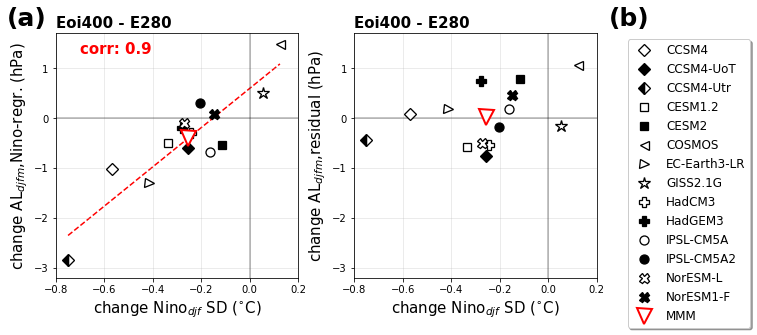

In [39]:
fig = plt.figure(figsize=(12,4.5))
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights, wspace=0.3)

#############################################################

xlims = [-0.8, 0.2]; 
ylims = [-3.2, 1.7];

ax = fig.add_subplot(spec[0])

x = nino_djf.sel(sim=sim2).std("time") - nino_djf.sel(sim=sim1).std("time")
y = ali_lrm.nino.sel(sim=sim2).std("time") - ali_lrm.nino.sel(sim=sim1).std("time")
# x = nino_djf.sel(sim=sim2).var("time") - nino_djf.sel(sim=sim1).var("time")
# y = ali_lrm.nino.sel(sim=sim2).var("time") - ali_lrm.nino.sel(sim=sim1).var("time")

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'change Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'change AL$_{djfm}$,Nino-regr. (hPa)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

x = x.isel(model=idx); y = y.isel(model=idx);
polyfit = np.polyfit(x,y,deg=1)
x_ = np.array([x.min(), x.max()]);
y_ = np.polyval(polyfit, x_)
ax.plot(x_, y_, 'r--',zorder=-1)

corr =  xs.pearson_r(x, y, dim='model').values
ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

ax.text(-1, 1.85, '(a)', fontsize = 25, fontweight = 'bold')

#############################################################

ax = fig.add_subplot(spec[1])

x = nino_djf.sel(sim=sim2).std("time") - nino_djf.sel(sim=sim1).std("time")
y = ali_lrm.res.sel(sim=sim2).std("time") - ali_lrm.res.sel(sim=sim1).std("time")

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')

        
ax.set_xlabel(r'change Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'change AL$_{djfm}$,residual (hPa)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

ax.text(0.25, 1.85, '(b)', fontsize = 25, fontweight = 'bold')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper center', shadow=True, ncol=1, fontsize=12)
ax.set_axis_off()


# plt.savefig('figures/paper/Figure6.png',dpi=300)


In [48]:
y = ali_lrm.res.sel(sim=sim2).std("time") - ali_lrm.res.sel(sim=sim1).std("time")
mae = np.abs(y).mean()
print(mae)

y = ali_lrm.nino.sel(sim=sim2).std("time") - ali_lrm.nino.sel(sim=sim1).std("time")
mae = np.abs(y).mean()
print(mae)

<xarray.DataArray 'res' ()>
array(0.47200116)
<xarray.DataArray 'nino' ()>
array(0.78559793)


## Plot sensitivity study ENSO-AL change and ECS/ESS

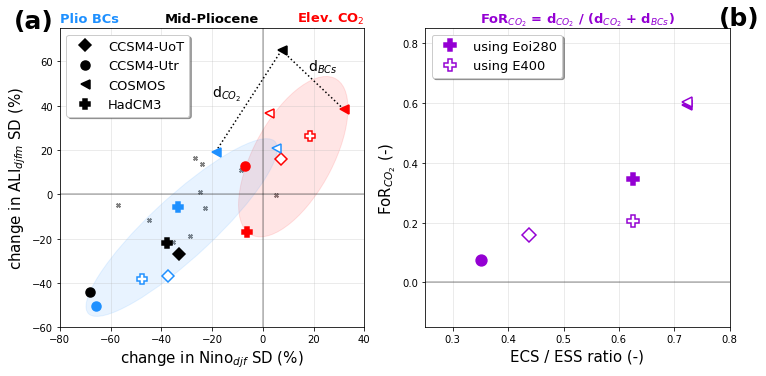

In [213]:
x1 = nino_sd.sel(sim=sim1); x2 = nino_sd.sel(sim=sim2); x3 = nino_sd.sel(sim=sim3); x4 = nino_sd.sel(sim=sim4);
y1 = ali_sd.sel(sim=sim1);  y2 = ali_sd.sel(sim=sim2);  y3 = ali_sd.sel(sim=sim3); y4 = ali_sd.sel(sim=sim4);

col1 = 'r'; 
col2 = 'dodgerblue'
col3 = 'darkviolet'

fig = plt.figure(figsize=(12,5.5))

ax = fig.add_subplot(121)

xlims = [-80, 40]; ylims = [-60, 75];
ax.set_xlim(xlims); ax.set_ylim(ylims);
ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)

ellipse = Ellipse((12, 17), 78, 32, angle=66, alpha=0.1, color=col1)
ax.add_artist(ellipse)

ellipse = Ellipse((-32, -15), 107, 26, angle=47, alpha=0.1, color=col2)
ax.add_artist(ellipse)

x_ = 100 * (nino_djf.sel(sim=sim2).std("time") - nino_djf.sel(sim=sim1).std("time"))/nino_djf.sel(sim=sim1).std("time")
y_ = 100 * (ali_djfm.sel(sim=sim2).std("time") - ali_djfm.sel(sim=sim1).std("time"))/ali_djfm.sel(sim=sim1).std("time")

for i in range(len(modellist)):
    for i in idx:
        if i not in idx_sens:
            ax.scatter(x_[i], y_[i], marker = 'x', s = 10, color = 'gray')
            
j=2;
x21_ = 100*(x2[j]-x1[j])/x1[j]; y21_ = 100*(y2[j]-y1[j])/y1[j]; 
x31_ = 100*(x3[j]-x1[j])/x1[j]; y31_ = 100*(y3[j]-y1[j])/y1[j];
x23_ = 100*(x2[j]-x3[j])/x3[j]; y23_ = 100*(y2[j]-y3[j])/y3[j]; 

ax.plot([x31_, x21_], [y31_, y21_], ':', color='k')
ax.text(-20, 44, r'd$_{CO_2}$', fontsize = 14, color = 'k')
ax.plot([x23_, x21_], [y23_, y21_], ':', color='k')
ax.text(18, 56, r'd$_{BCs}$', fontsize = 14, color = 'k')

# plot model values
for j in range(len(idx_sens)):
    i = idx_sens[j];
    
    # full diff
    p1 = ax.plot(100*(x2[j]-x1[j])/x1[j], 100*(y2[j]-y1[j])/y1[j], label = modellist[i], marker = markers_sens[j], markersize = msize_sens[j], 
            color='k', linestyle='None', markeredgecolor = 'k', fillstyle = 'full', markeredgewidth=1.5)
    
    # Plio BCs
    ax.plot(100*(x3[j]-x1[j])/x1[j], 100*(y3[j]-y1[j])/y1[j], marker = markers_sens[j], markersize = msize_sens[j], 
            color=col2, linestyle='None', markeredgecolor = col2, fillstyle = 'full', markeredgewidth=1.5)
    ax.plot(100*(x2[j]-x4[j])/x4[j], 100*(y2[j]-y4[j])/y4[j], marker = markers_sens[j], markersize = msize_sens[j], 
            color='w', linestyle='None', markeredgecolor = col2, fillstyle = 'full', markeredgewidth=1.5)
    
    # CO2 effect
    ax.plot(100*(x2[j]-x3[j])/x3[j], 100*(y2[j]-y3[j])/y3[j], marker = markers_sens[j], markersize = msize_sens[j], 
            color=col1, linestyle='None', markeredgecolor = col1, fillstyle = 'full', markeredgewidth=1.5)
    ax.plot(100*(x4[j]-x1[j])/x1[j], 100*(y4[j]-y1[j])/y1[j], marker = markers_sens[j], markersize = msize_sens[j], 
            color='w', linestyle='None', markeredgecolor = col1, fillstyle = 'full', markeredgewidth=1.5)

ax.set_xlabel('change in Nino$_{djf}$ SD (%)', fontsize=15);
ax.set_ylabel('change in ALI$_{djfm}$ SD (%)', fontsize=15)
ax.set_title("Plio BCs", fontsize=13, loc='left', fontweight='bold', color=col2)
ax.set_title("Mid-Pliocene", fontsize=13, loc='center', fontweight='bold', color='k')
ax.set_title("Elev. CO$_2$", fontsize=13, loc='right', fontweight='bold', color=col1)
ax.grid(alpha=0.3)

ax.legend(loc='upper left', shadow=True, ncol=1, fontsize=13)

ax.text(-98, 75, '(a)', fontsize = 25, fontweight = 'bold')


ax = fig.add_subplot(122)

xlims = [0.25, 0.8]; ylims = [-.15, 0.85];
ax.set_xlim(xlims); ax.set_ylim(ylims);
ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)

x = (ecs/ess).isel(model=idx_sens)
# x = ecs.isel(model=idx_sens)
y1 = f3_bcs; y2 = f4_bcs;

    
for j in range(len(idx_sens)):
    i = idx_sens[j];
    p1, = ax.plot(x[j], y1[j], marker = markers_sens[j], markersize = 1.2*msize_sens[j], 
            color=col3, linestyle='None', markeredgecolor = col3, fillstyle = 'full', markeredgewidth=1.5)
    p2, = ax.plot(x[j], y2[j], marker = markers_sens[j], markersize = 1.2*msize_sens[j], 
            color='w', linestyle='None', markeredgecolor = col3, fillstyle = 'full', markeredgewidth=1.5)

ax.legend([p1,p2], ['using Eoi280', 'using E400'], loc='upper left', shadow=True, ncol=1, fontsize=13)

ax.set_xlabel('ECS / ESS ratio (-)', fontsize=15);
ax.set_ylabel(r'FoR$_{CO_2}$ (-)', fontsize=15)
ax.set_title(r"FoR$_{CO_2}$ = d$_{CO_2}$ / (d$_{CO_2}$ + d$_{BCs}$)", fontsize=13, loc='center', fontweight='bold', color=col3)
ax.grid(alpha=0.3)

ax.text(0.78, 0.86, '(b)', fontsize = 25, fontweight = 'bold')


plt.subplots_adjust(wspace=0.2)

# plt.savefig('figures/enso_al_sensitivity_ECS_v2.png',dpi=300)
plt.savefig('figures/paper/Figure7.png',dpi=300)



***
***
***
***
***

# Supplementary material

## Supplementary computations and data selections

## compute PDO

In [9]:

# PDO_sd = np.zeros((2, len(modellist)))

remove_regr  = True;
eofs_scaling = False;
select_FMA   = False;

for j in range(len(simlist)):

    sim = simlist[j]

    for i in range(len(modellist)):

        ## PDO
        
        sst_file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+sst_name
        sst = xr.open_dataset(sst_file).sst
        ssta = select_anomalies(sst, clim=True, regr=remove_regr)
        
        if select_FMA == True:
            # select fma
            ssta = select_winter(ssta, "FMA")

        gw = compute_gridweights(ssta)
        ssta_pdo   = ssta.sel(lat = slice(20, 70)).sel(lon = slice(120, 260))
        gw_pdo     = gw.sel(lat = slice(20, 70)).sel(lon = slice(120, 260))
        
        PDO = EOF_analysis(ssta_pdo, weights = gw_pdo, n=1, scale_eofs = eofs_scaling)
        PDO_wnp = PDO.isel(mode=0).eofs.sel(lon = slice(140,170), lat = slice(37,45)).mean()
        sign = 1;
        if PDO_wnp < 0.: sign = -1;
        PDO_pc = sign * PDO.isel(mode=0).pcs

        # select fma pdo sd
#         PDO_sd[j,i] = sign * PDO.isel(mode=0).eofs.std()

        if i==0:
            PDO_pc_ = PDO_pc; 
        else:
            PDO_pc_ = xr.concat([PDO_pc_, PDO_pc], dim="model")

    if j==0:
        PDO_PC = PDO_pc_; 
    else:
        PDO_PC = xr.concat([PDO_PC, PDO_pc_], dim="sim")

if select_FMA == True:
    pdo_fma_pc = PDO_PC
    pdo_fma_pc["sim"] = simlist; 
    pdo_fma_pc["model"] = modellist;
else:
    pdo_mon_pc = PDO_PC
    pdo_mon_pc["sim"] = simlist; 
    pdo_mon_pc["model"] = modellist;
    
# save monthly PDO index
ds = pdo_mon_pc.to_dataset(name = "pdo")
ds.pdo.attrs["units"] = 'deg C'
ds.pdo.attrs["description"] = 'monthly PDO index'
ds.to_netcdf('PlioMIP2 data/PlioMIP2_PDO_indices.nc', mode='w')

# PDO_fma_SD = xr.DataArray(data = PDO_sd, dims = ["sim", "model"], coords = dict(sim = ("sim", simlist), model = ("model", modellist)))

In [14]:
ds_pdo = xr.open_dataset('PlioMIP2 data/PlioMIP2_PDO_indices.nc')
ds     = xr.open_dataset('PlioMIP2 data/PlioMIP2_NINO_ALI_indices.nc')

### Compute PDO for NOAA

In [12]:
sst = sst_obs
ssta = select_anomalies(sst, clim=True, regr=False)

gw = compute_gridweights(ssta)
ssta_pdo   = ssta.sel(lat = slice(20, 70)).sel(lon = slice(120, 260))
gw_pdo     = gw.sel(lat = slice(20, 70)).sel(lon = slice(120, 260))

PDO = EOF_analysis(ssta_pdo, weights = gw_pdo, n=1, scale_eofs = False)
PDO_wnp = PDO.isel(mode=0).eofs.sel(lon = slice(140,170), lat = slice(37,45)).mean()
sign = 1;
if PDO_wnp < 0.: sign = -1;
PDO_pc = sign * PDO.isel(mode=0).pcs

pdo_mon_pc_obs = PDO_pc

## Compute Nino - SLPa correlation

In [15]:

dlat = 2; dlon = 2; #cutoff for set extent
min_lat = 20-dlat; max_lat = 70+dlat; min_lon = 120-dlon; max_lon = 260+dlon; 

index = nino_djf;
variable = "slp"

for j in range(len(simlist)):
    
    sim = simlist[j];

    for i in range(len(modellist)):
        model = modellist[i]

        # load data
        if variable == "slp":
            file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+slp_name
            data  = xr.open_dataset(file).slp; 
        elif variable == "sst":
            file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+sst_name
            data  = xr.open_dataset(file).sst; 
        elif variable == "prect":
            file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+prect_name
            data  = xr.open_dataset(file).prect; 

        # remove climatology and select DJFM
        data_a = select_anomalies(data, clim = True, regr = False)
        data_a = select_winter(data_a, mode="DJFM");

        # you can select a region here
        data_a          = data_a.sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
        interp_ref_ = interp_ref.sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))

        # select index
        index_ = index.isel(model=i).sel(sim=sim)
        
        # get regression, correlation, pval
        stat = compute_regression(index_, data_a, dim = "time")
        stat = stat.interp_like(interp_ref)

        if i==0: stat_ = stat
        else: stat_ = xr.concat([stat_, stat], dim='model')
            
    if j==0: stat__ = stat_
    else: stat__ = xr.concat([stat__, stat_], dim='sim')
        
nino_slp_regr = stat__

print('done')

done


In [16]:

dlat = 2; dlon = 2; #cutoff for set extent
min_lat = 20-dlat; max_lat = 70+dlat; min_lon = 120-dlon; max_lon = 260+dlon; 

index = nino_obs_djf;
data = slp_obs;

# remove climatology and select DJFM
data_a = select_anomalies(data, clim = True, regr = False)
data_a = select_winter(data_a, mode="DJFM");

# you can select a region here
data_a          = data_a.sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
interp_ref_ = interp_ref.sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))

# select index
index_ = index

# get regression, correlation, pval
stat = compute_regression(index_, data_a, dim = "time")
stat = stat.interp_like(interp_ref)
        
nino_slp_regr_obs = stat

print('done')

done


## Compute Indo-Pac / WPac-Ind. SST gradient anomaly

In [12]:

# remove linear regression? (takes some extra time)
remove_regr = False;

# lat lon selection
dlat = 2; dlon = 2; #cutoff for set extent
min_lat = -20-dlat; max_lat = 20+dlat; min_lon = 40-dlon; max_lon = 180+dlon; 

interp_ref_ = interp_ref.sel(lat = slice(min_lat - dlat, max_lat + dlat), lon = slice(min_lon - dlon, max_lon + dlon))

for j in range(len(simlist)):
    
    sim = simlist[j];

    for i in range(len(modellist)):

        # load model, select data
        model = modellist[i]
        file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+sst_name
        sst  = xr.open_dataset(file).sst; 
        
        sst_mean = sst.mean("time").sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
        sst_mean = sst_mean.interp_like(interp_ref).sel(lat = slice(min_lat, max_lat), lon = slice(min_lon, max_lon))
        
        if i==0:
            sst_mean_ = sst_mean;
        else:
            sst_mean_ = xr.concat([sst_mean_, sst_mean], dim="model")
            
    if j==0:
        SST_mean = sst_mean_
    else:
        SST_mean = xr.concat([SST_mean, sst_mean_], dim="sim")
        
SST_mean["sim"] = simlist; SST_mean["model"] = modellist;


In [13]:
io  = SST_mean.sel(lat=slice(-10, 15), lon=slice(40,   90)).mean({"lat","lon"})
wp  = SST_mean.sel(lat=slice(-10, 15), lon=slice(130, 180)).mean({"lat","lon"})
indopac = io - wp
d_indopac = indopac.sel(sim=sim2) - indopac.sel(sim=sim1)

wpac_ind = wp - io
d_wpac_ind = wpac_ind.sel(sim=sim2) - wpac_ind.sel(sim=sim1)

## Compute North Pacific SST anomaly (in AL region)

In [89]:

# remove linear regression? (takes some extra time)
remove_regr = False;

for j in range(len(simlist)):
    
    sim = simlist[j];

    for i in range(len(modellist)):

        # load model, select data
        model = modellist[i]
        file = folder+"/"+modellist[i]+"/"+sim+"/"+sim+sst_name
        sst  = xr.open_dataset(file).sst; 
        
        # select DJFM
        sst = select_winter(sst, 'DJF')
    
        gw = compute_gridweights(sst).sel(lat=slice(30, 65)).sel(lon=slice(160, 220));
        sst_mean = sst.mean("time").sel(lat=slice(30, 65)).sel(lon=slice(160, 220))
        np_sst = sst_mean.weighted(gw).mean("lat").mean("lon")
        
        if i==0:
            np_sst_ = np_sst;
        else:
            np_sst_ = xr.concat([np_sst_, np_sst], dim="model")
            
    if j==0:
        NP_sst = np_sst_
    else:
        NP_sst = xr.concat([NP_sst, np_sst_], dim="sim")
        
NP_sst["sim"] = simlist; NP_sst["model"] = modellist;


### Select some literature values

In [17]:

d_nino  = nino_djf.sel(sim=sim2).std("time")  - nino_djf.sel(sim=sim1).std("time")
# d_np_sst = NP_sst.sel(sim=sim2) - NP_sst.sel(sim=sim1)
# d_ali_res = ali_lrm.res.sel(sim=sim2).std("time") - ali_lrm.res.sel(sim=sim1).std("time")

d_pwc_lon = lit_data.d_pwc_lon
d_amoc = lit_data.d_amoc
d_sie = lit_data.d_jan_asie
d_asat = lit_data.d_ann_asat

# Supplementary Figures

## Plot lead-lags

In [68]:
# levels = np.concatenate([np.arange(-.9, 0.0, 0.1), np.arange(0.1, 1.0, 0.1)])
levels = np.arange(-0.9, 0.9+0.1, 0.1)
ls     = np.where(levels>0.0, '-', '--')

def fmt(x):
    s = f"{x:.1f}"
    return f"{s}"

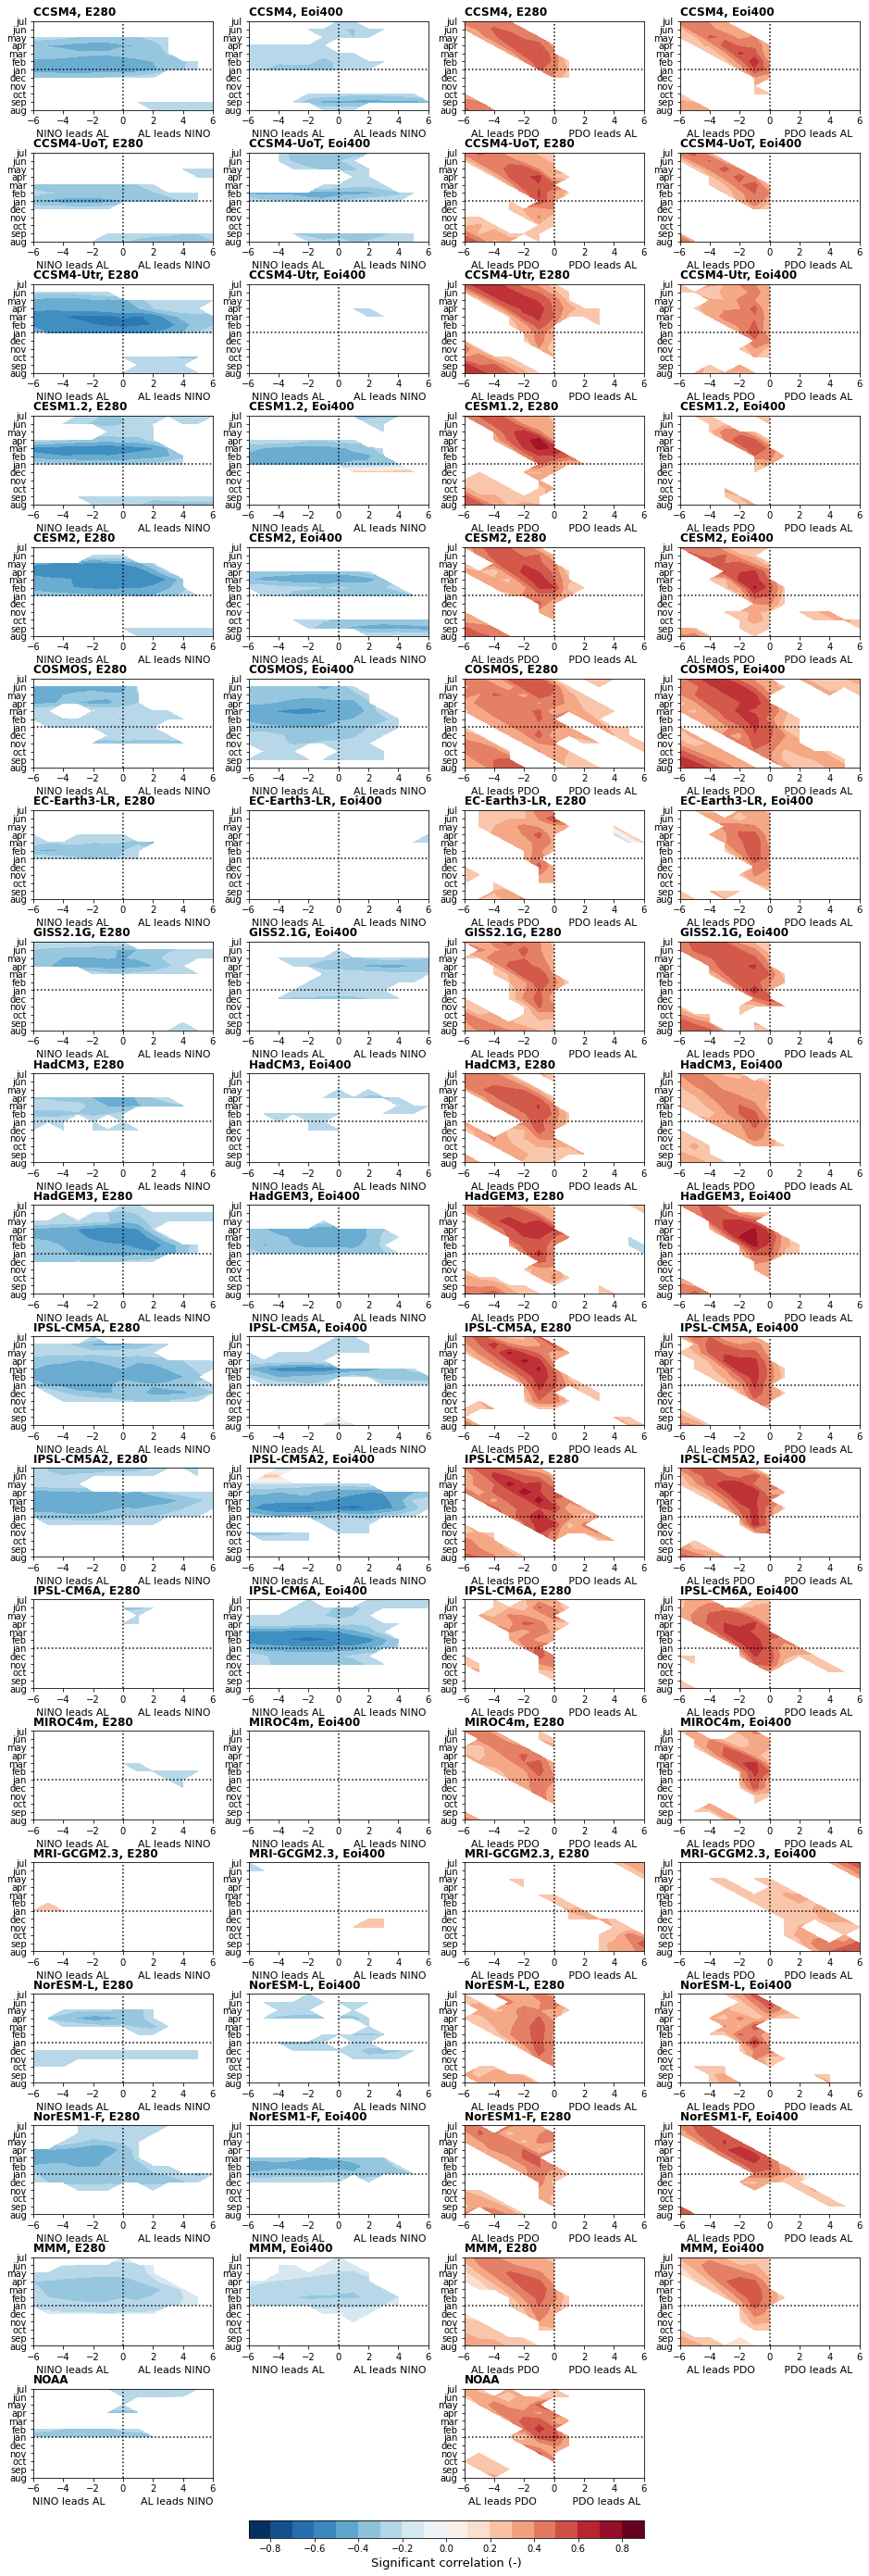

In [69]:

name_al = "AL";  name_nino = "NINO"; name_pdo = "PDO";
var_al = ds.ali; var_nino = ds.nino;  var_pdo  = pdo_mon_pc;

fig = plt.figure(figsize = (16, 50))

Nfig = 4; Nadd = 2;
widths = [1, 1, 1, 1]; heights = list(np.ones(len(modellist) + Nadd)) + [0.2];
spec = fig.add_gridspec(ncols = 4, nrows = len(modellist)+Nadd+1, width_ratios=widths, height_ratios=heights, wspace=0.2, hspace=0.5)

for i in range(len(modellist)):
    
    model = modellist[i]

    var1 = var_al; name1 = name_al; var2 = var_nino; name2 = name_nino;
    
    ax = fig.add_subplot(spec[i,0])
    sim=sim1 # E280
    
    LL1, LL1_p = lead_lag_corr(var1.sel(model = model, sim = sim), var2.sel(model = model, sim = sim), model, sim)
    ax.contourf(LL1.lag, LL1.month, LL1.where(LL1_p<0.05), cmap='RdBu_r', levels=levels)
    ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
    ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
    ax.set_title(f"{model}, {sim}", loc='left', fontsize = 12, fontweight='bold'); 
    
    ax = fig.add_subplot(spec[i,1])
    sim=sim2 # Eoi400
    
    LL2, LL2_p = lead_lag_corr(var1.sel(model = model, sim = sim), var2.sel(model = model, sim = sim), model, sim)
    ax.contourf(LL2.lag, LL2.month, LL2.where(LL2_p<0.05), cmap='RdBu_r', levels=levels)
    ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
    ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
    ax.set_title(f"{model}, {sim}", loc='left', fontsize = 12, fontweight='bold'); 
    
    LLan1 = LL1; LLan1_p = LL1_p; LLan2 = LL2; LLan2_p = LL2_p;
        
    ########################################################################
    
    var1 = var_pdo; name1 = name_pdo; var2 = var_al; name2 = name_al;
    
    ax = fig.add_subplot(spec[i,2])
    sim=sim1 # E280
    
    LL1, LL1_p = lead_lag_corr(var1.sel(model = model, sim = sim), var2.sel(model = model, sim = sim), model, sim)
    ax.contourf(LL1.lag, LL1.month, LL1.where(LL1_p<0.05), cmap='RdBu_r', levels=levels)
    ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
    ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
    ax.set_title(f"{model}, {sim}", loc='left', fontsize = 12, fontweight='bold'); 
    
    ax = fig.add_subplot(spec[i,3])
    sim=sim2 # Eoi400
    
    LL2, LL2_p = lead_lag_corr(var1.sel(model = model, sim = sim), var2.sel(model = model, sim = sim), model, sim)
    ax.contourf(LL2.lag, LL2.month, LL2.where(LL2_p<0.05), cmap='RdBu_r', levels=levels)
    ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
    ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
    ax.set_title(f"{model}, {sim}", loc='left', fontsize = 12, fontweight='bold'); 
    
    LLpa1 = LL1; LLpa1_p = LL1_p; LLpa2 = LL2; LLpa2_p = LL2_p;
    
    ########################################################################
    
    if i==0:
        LLan_pi   = LLan1; LLan_pi_p   = LLan1_p;
        LLan_plio = LLan2; LLan_plio_p = LLan2_p;
        
        LLpa_pi   = LLpa1; LLpa_pi_p   = LLpa1_p;
        LLpa_plio = LLpa2; LLpa_plio_p = LLpa2_p;
    else:
        LLan_pi     = xr.concat([LLan_pi, LLan1], dim="model");
        LLan_pi_p   = xr.concat([LLan_pi_p, LLan1_p], dim = "model")
        LLan_plio   = xr.concat([LLan_plio, LLan2], dim="model");
        LLan_plio_p = xr.concat([LLan_plio_p, LLan2_p], dim="model")
        
        LLpa_pi     = xr.concat([LLpa_pi, LLpa1], dim="model");
        LLpa_pi_p   = xr.concat([LLpa_pi_p, LLpa1_p], dim = "model")
        LLpa_plio   = xr.concat([LLpa_plio, LLpa2], dim="model");
        LLpa_plio_p = xr.concat([LLpa_plio_p, LLpa2_p], dim="model")
    

########################################################################

# Plot Ensemble means E280
name1 = name_al; name2 = name_nino;

ax = fig.add_subplot(spec[len(modellist),0])
LL = LLan_pi.mean("model"); counts = xr.where((LLan_pi_p)<0.05, 1, 0)

ax.contourf(LL.lag, LL.month, LL.where(counts.sum("model")>6), cmap='RdBu_r', levels=levels)
ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
ax.set_title(f"MMM, E280", loc='left', fontsize = 12, fontweight='bold'); 

ax = fig.add_subplot(spec[len(modellist),1])
LL = LLan_plio.mean("model"); counts = xr.where((LLan_plio_p)<0.05, 1, 0)

ax.contourf(LL.lag, LL.month, LL.where(counts.sum("model")>6), cmap='RdBu_r', levels=levels)
ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
ax.set_title(f"MMM, Eoi400", loc='left', fontsize = 12, fontweight='bold'); 

name1 = name_pdo; name2 = name_al;

ax = fig.add_subplot(spec[len(modellist),2])
LL = LLpa_pi.mean("model"); counts = xr.where((LLpa_pi_p)<0.05, 1, 0)

ax.contourf(LL.lag, LL.month, LL.where(counts.sum("model")>6), cmap='RdBu_r', levels=levels)
ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
ax.set_title(f"MMM, E280", loc='left', fontsize = 12, fontweight='bold'); 

ax = fig.add_subplot(spec[len(modellist),3])
LL = LLpa_plio.mean("model"); counts = xr.where((LLpa_plio_p)<0.05, 1, 0)

ax.contourf(LL.lag, LL.month, LL.where(counts.sum("model")>6), cmap='RdBu_r', levels=levels)
ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
ax.set_xlabel(f"{name2} leads {name1}         {name1} leads {name2}", fontsize = 11)
ax.set_title(f"MMM, Eoi400", loc='left', fontsize = 12, fontweight='bold'); 

########################################################################

# NOAA

name_al = "AL";  name_nino = "NINO"; name_pdo = "PDO";
var_al = ali_obs; var_nino = nino_obs;  var_pdo  = pdo_mon_pc_obs;

model = 'NOAA'; sim = 'preind'

ax = fig.add_subplot(spec[len(modellist)+1,0])
var1 = var_al; name1 = name_al; var2 = var_nino; name2 = name_nino;

LL1, LL1_p = lead_lag_corr(var1, var2, model, sim)
ax.contourf(LL1.lag, LL1.month, LL1.where(LL1_p<0.05), cmap='RdBu_r', levels=levels)
ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
ax.set_xlabel(f"{name2} leads {name1}           {name1} leads {name2}", fontsize = 11)
ax.set_title(f"NOAA", loc='left', fontsize = 12, fontweight='bold'); 

ax = fig.add_subplot(spec[len(modellist)+1,2])
var1 = var_pdo; name1 = name_pdo; var2 = var_al; name2 = name_al;

LL1, LL1_p = lead_lag_corr(var1, var2, model, sim)
ax.contourf(LL1.lag, LL1.month, LL1.where(LL1_p<0.05), cmap='RdBu_r', levels=levels)
ax.plot([0, 0], ["aug", "jul"],  'k:'); ax.plot([-6, 6], ["jan", "jan"], 'k:');
ax.set_xlabel(f"{name2} leads {name1}           {name1} leads {name2}", fontsize = 11)
ax.set_title(f"NOAA", loc='left', fontsize = 12, fontweight='bold'); 

########################################################################

cmap = plt.get_cmap('RdBu_r');
ax = fig.add_subplot(spec[len(modellist)+2,1:3])
norm = matplotlib.colors.BoundaryNorm(levels, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal'); 
cbar.set_label(f'Significant correlation (-)', fontsize=13); 

plt.savefig('figures/supplement/lead_lags_full.png',dpi=300)



## Plot Nino - SLPa correlations

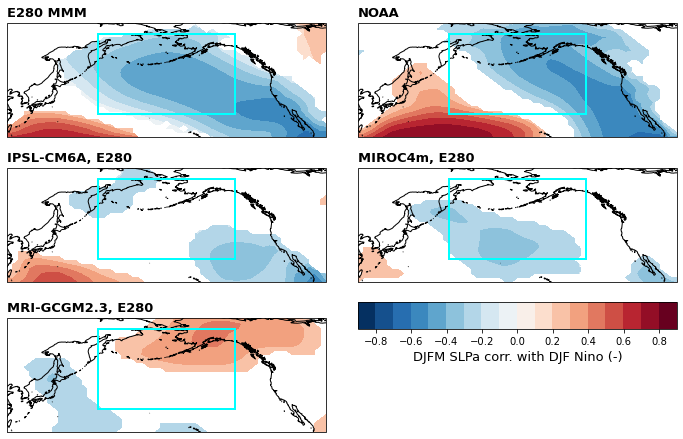

In [102]:
dlat = 2; dlon = 2; #cutoff for set extent
min_lat = 20-dlat; max_lat = 70+dlat; min_lon = 120-dlon; max_lon = 260+dlon; 


levels1 = np.arange(-0.9, 0.9+0.1, 0.1)
cmap1 = plt.cm.RdBu_r

fig = plt.figure(figsize=(12,8))
clon=-105

widths = [1, 1]; heights = [1, 1, 0.2, 0.8];
spec = fig.add_gridspec(ncols=2, nrows=4, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)


corr = nino_slp_regr.sel(sim=sim1).isel(model=idx).mean("model").corr;
pval = nino_slp_regr.sel(sim=sim1).isel(model=idx).pval; counts = xr.where((pval)<0.05, 1, 0);

ax = fig.add_subplot(spec[0,0], projection=ccrs.PlateCarree(central_longitude=clon))
(corr.where(counts.sum("model")>6)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title(f"E280 MMM", loc="left", fontsize=13, fontweight='bold')

corr = nino_slp_regr_obs.corr;
pval = nino_slp_regr_obs.pval;

ax = fig.add_subplot(spec[0,1], projection=ccrs.PlateCarree(central_longitude=clon))
(corr.where(pval<0.05)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title(f"NOAA", loc="left", fontsize=13, fontweight='bold')

model = "IPSL-CM6A"
corr = nino_slp_regr.sel(model = model, sim=sim1).corr;
pval = nino_slp_regr.sel(model = model, sim=sim1).pval;

ax = fig.add_subplot(spec[1,0], projection=ccrs.PlateCarree(central_longitude=clon))
(corr.where(pval<0.05)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title(f"{model}, {sim1}", loc="left", fontsize=13, fontweight='bold')

model = "MIROC4m"
corr = nino_slp_regr.sel(model = model, sim=sim1).corr;
pval = nino_slp_regr.sel(model = model, sim=sim1).pval;

ax = fig.add_subplot(spec[1,1], projection=ccrs.PlateCarree(central_longitude=clon))
(corr.where(pval<0.05)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title(f"{model}, {sim1}", loc="left", fontsize=13, fontweight='bold')

model = "MRI-GCGM2.3"
# model = "GISS2.1G"
corr = nino_slp_regr.sel(model = model, sim=sim1).corr;
pval = nino_slp_regr.sel(model = model, sim=sim1).pval;

ax = fig.add_subplot(spec[2:4,0], projection=ccrs.PlateCarree(central_longitude=clon))
(corr.where(pval<0.05)).plot.contourf(ax=ax, transform = ccrs.PlateCarree(), zorder=1, cmap=cmap1, levels=levels1, add_colorbar =False)
ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))
ax.coastlines(zorder=2); ax.set_extent([min_lon+dlon, max_lon-dlon, min_lat+dlat, max_lat-dlat], crs=ccrs.PlateCarree())
ax.set_title(''); ax.set_title(f"{model}, {sim1}", loc="left", fontsize=13, fontweight='bold')


ax = fig.add_subplot(spec[2,1])
norm = matplotlib.colors.BoundaryNorm(levels1, cmap1.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap1, norm=norm, orientation='horizontal'); 
cbar.set_label(f'DJFM SLPa corr. with DJF Nino (-)', fontsize=13); 

# plt.savefig('figures/supplement/Nino_SLP_corr.png', dpi=300)


## Figure: DJF Nino and DJFM ALI correlations and linear slopes

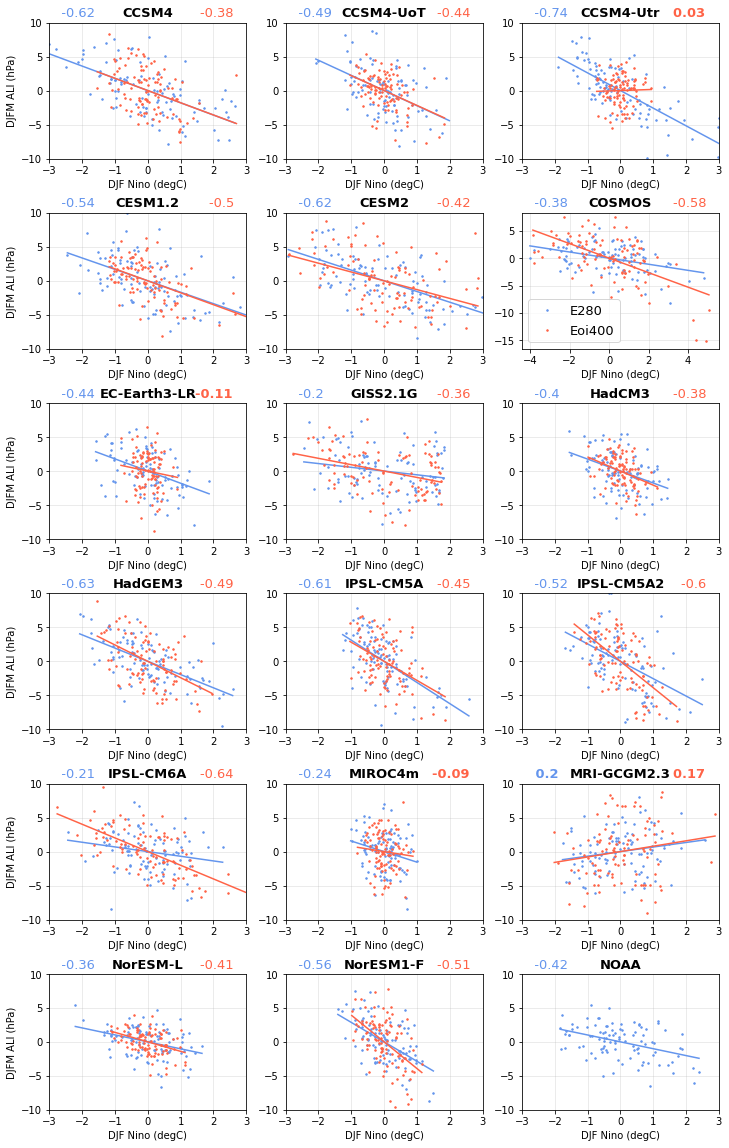

In [45]:
col1 = 'cornflowerblue'
col2 = 'tomato'

fig = plt.figure(figsize = (12, 20), constrained_layout=False)


for i in range(len(modellist)):
    model = modellist[i]
    
    X = nino_djf.sel(model=model)
    Y = ali_djfm.sel(model=model)

    ax = fig.add_subplot(6, 3, i+1)

    if model=="COSMOS":
        d_ax = 1.1; 
        ax.set_xlim([d_ax*X.min(), d_ax*X.max()]); 
        ax.set_ylim([d_ax*Y.min(), d_ax*Y.max()]); 
    else:
        ax.set_xlim([-3, 3]); 
        ax.set_ylim([-10, 10]); 

    ax.grid(alpha=.3)

    #########

    sim = sim1;
    x = X.sel(sim=sim); y = Y.sel(sim=sim)
    ax.plot(x,y, '.', color=col1, markersize = 3, label = sim1)
    
    stat1 = compute_regression(x, y, dim='time')
    x_ = np.array([x.min(), x.max()]); y_ = stat1.regr.values * x_
    ax.plot(x_, y_, '-', color=col1)

    #########

    sim = sim2;
    x = X.sel(sim=sim); y = Y.sel(sim=sim)
    ax.plot(x,y, '.', color=col2, markersize = 3, label = sim2)

    stat2 = compute_regression(x, y, dim="time")
    x_ = np.array([x.min(), x.max()]); y_ = stat2.regr.values * x_

    ax.plot(x_, y_, '-', color=col2)
    
    #############
    if stat1.pval>0.05 or stat1.corr>0: fw1='bold';
    else: fw1='normal';
    if stat2.pval>0.05 or stat2.corr>0: fw2='bold';
    else: fw2='normal';
    
    ax.set_title(f'   {np.round(stat1.corr.values,2)}', fontsize=13, fontweight=fw1, color=col1, loc='left')
    ax.set_title(f'{np.round(stat2.corr.values,2)}   ', fontsize=13, fontweight=fw2, color=col2, loc='right')

    ax.set_title(model, loc='center', fontsize = 13, fontweight='bold')
    ax.set_xlabel('DJF Nino (degC)')
    
    if model=="COSMOS":
        ax.legend(fontsize=13)
    if np.mod(i,3)==0:
        ax.set_ylabel('DJFM ALI (hPa)')
        
#############        

x = nino_obs_djf
y = ali_obs_djfm

ax = fig.add_subplot(6, 3, len(modellist)+1)

ax.plot(x,y, '.', color=col1, markersize = 3, label = sim1)
stat1 = compute_regression(x, y, dim='time')
x_ = np.array([x.min(), x.max()]); y_ = stat1.regr.values * x_;
ax.plot(x_, y_, '-', color=col1)

ax.set_xlim([-3, 3]); ax.set_ylim([-10, 10]); ax.grid(alpha=.3)

if stat1.pval>0.05 or stat1.corr>0: fw1='bold'; 
else: fw1='normal';

ax.set_title(f'   {np.round(stat1.corr.values,2)}', fontsize=13, fontweight=fw1, color=col1, loc='left')
ax.set_title("NOAA", loc='center', fontsize = 13, fontweight='bold')
ax.set_xlabel('DJF Nino (degC)')

plt.subplots_adjust(wspace=0.2, hspace=0.4)

plt.savefig('figures/supplement/Nino_ALI_corr_slope.png', dpi=300)

## Plot Linear regression change v ENSO/AL change

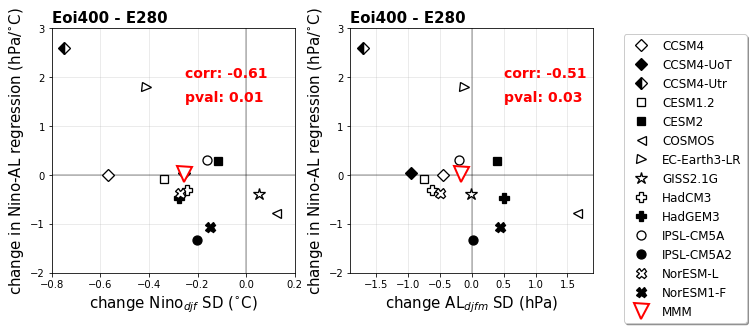

In [65]:
fig = plt.figure(figsize=(12,4.5))
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights, wspace=0.3)

#############################################################

xlims = [-0.8, 0.2]; 
ylims = [-2., 3];

ax = fig.add_subplot(spec[0])

x = nino_djf.sel(sim=sim2).std("time") - nino_djf.sel(sim=sim1).std("time")
y = linslope.sel(sim=sim2) - linslope.sel(sim=sim1)

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'change Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'change in Nino-AL regression (hPa/$^{\circ}$C)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

stat = compute_regression(x, y, dim='model')
ax.text(-0.25, 2, f"corr: {np.round(stat.corr.values,2)}", fontsize=14, fontweight='bold' ,color='r')
ax.text(-0.25, 1.5, f"pval: {np.round(stat.pval.values,2)}", fontsize=14, fontweight='bold' ,color='r')

# ax.text(-1, 1.85, '(a)', fontsize = 25, fontweight = 'bold')

#############################################################

xlims = [-1.9, 1.9]; 
ylims = [-2., 3];

ax = fig.add_subplot(spec[1])

x = ali_djfm.sel(sim=sim2).std("time") - ali_djfm.sel(sim=sim1).std("time")
y = linslope.sel(sim=sim2) - linslope.sel(sim=sim1)

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
        linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'change AL$_{djfm}$ SD (hPa)', fontsize=15)
ax.set_ylabel(r'change in Nino-AL regression (hPa/$^{\circ}$C)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

stat = compute_regression(x, y, dim='model')
ax.text(0.5, 2, f"corr: {np.round(stat.corr.values,2)}", fontsize=14, fontweight='bold' ,color='r')
ax.text(0.5, 1.5, f"pval: {np.round(stat.pval.values,2)}", fontsize=14, fontweight='bold' ,color='r')

# ax.text(0.25, 1.85, '(b)', fontsize = 25, fontweight = 'bold')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper center', shadow=True, ncol=1, fontsize=12)
ax.set_axis_off()


plt.savefig('figures/supplement/change_in_regression.png',dpi=300)


## Plot AL residual change vs other changes in NH

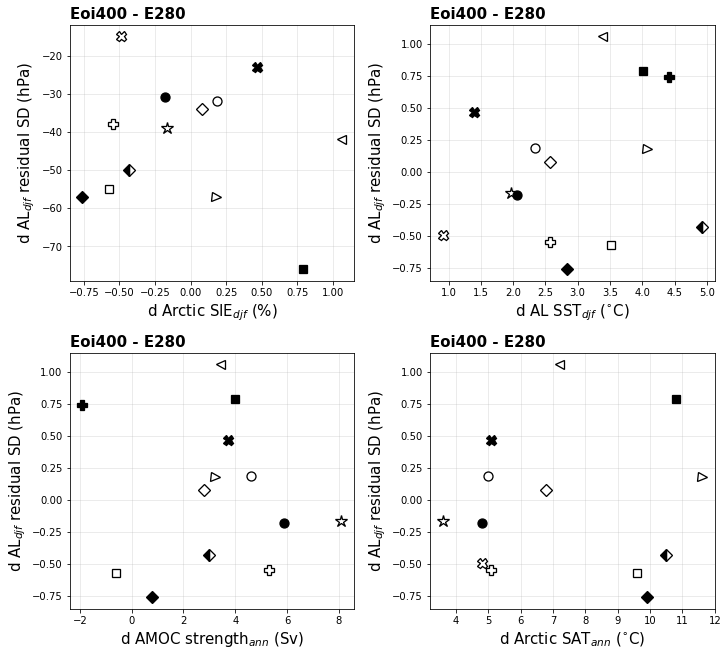

In [97]:
fig = plt.figure(figsize=(10,9), constrained_layout=True)
widths = [1, 1]; heights = [1, 1];
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

#############################################################

# xlims = [-0.7, .9]; ylims = [-30, 60];

ax = fig.add_subplot(spec[0])

x = d_ali_res
y = d_sie

# ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
# ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

ax.set_xlabel(r'd Arctic SIE$_{djf}$ (%)', fontsize=15);
ax.set_ylabel(r'd AL$_{djf}$ residual SD (hPa)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# stat = compute_regression(x,y,dim="model")
# ax.text(0.2, 40, f"corr: {np.round(stat.corr.values,2)}", fontsize=15, fontweight='bold' ,color='r')
# ax.text(0.2, 30, f"pval: {np.round(stat.pval.values,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

# xlims = [-0.9, 0.3]; ylims = [-30, 60];

ax = fig.add_subplot(spec[1])

x = d_np_sst
y = d_ali_res

# ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
# ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd AL SST$_{djf}$ ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd AL$_{djf}$ residual SD (hPa)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# stat = compute_regression(x,y,dim="model")
# ax.text(-0.7, 40, f"corr: {np.round(stat.corr.values,2)}", fontsize=15, fontweight='bold' ,color='r')
# ax.text(-0.7, 30, f"pval: {np.round(stat.pval.values,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

# xlims = [-0.9, 0.3]; ylims = [-0.7, .9];

ax = fig.add_subplot(spec[2])

x = d_amoc
y = d_ali_res

# ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
# ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd AMOC strength$_{ann}$ (Sv)', fontsize=15);
ax.set_ylabel(r'd AL$_{djf}$ residual SD (hPa)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# stat = compute_regression(x,y,dim="model")
# ax.text(-0.7, -0.3, f"corr: {np.round(stat.corr.values,2)}", fontsize=15, fontweight='bold' ,color='r')
# ax.text(-0.7, -0.45, f"pval: {np.round(stat.pval.values,2)}", fontsize=15, fontweight='bold' ,color='r')


#############################################################

# xlims = [-0.9, 0.3]; ylims = [-0.7, .9];

ax = fig.add_subplot(spec[3])

x = d_asat
y = d_ali_res

# ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
# ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd Arctic SAT$_{ann}$ ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd AL$_{djf}$ residual SD (hPa)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# stat = compute_regression(x,y,dim="model")
# ax.text(-0.7, -0.3, f"corr: {np.round(stat.corr.values,2)}", fontsize=15, fontweight='bold' ,color='r')
# ax.text(-0.7, -0.45, f"pval: {np.round(stat.pval.values,2)}", fontsize=15, fontweight='bold' ,color='r')


plt.savefig('figures/supplement/AL_residual_change.png',dpi=300)


## Plot ENSO change v changes in tropical Pacific mean climate

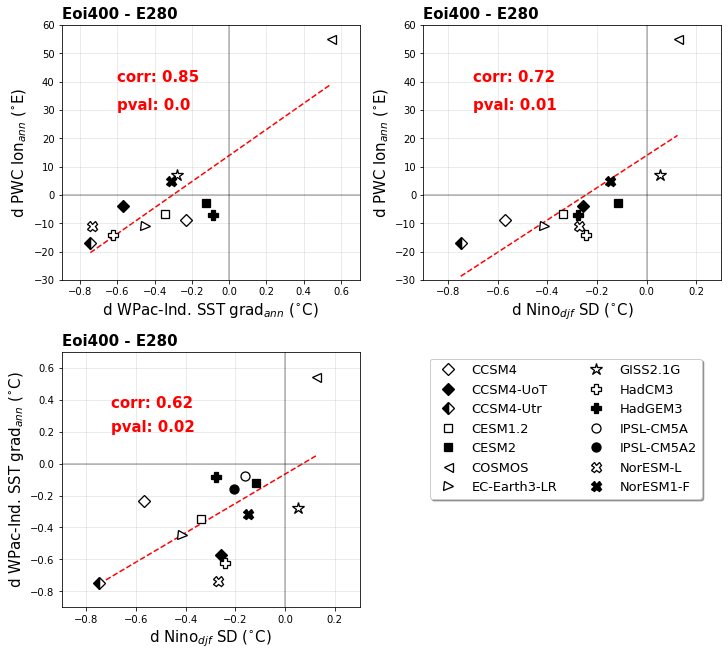

In [20]:
fig = plt.figure(figsize=(10,9), constrained_layout=True)
widths = [1, 1]; heights = [1, 1];
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths, height_ratios=heights)

#############################################################

#xlims = [-0.7, .9]; 
xlims = [-.9, 0.7]
ylims = [-30, 60];

ax = fig.add_subplot(spec[0])

# x = d_indopac
x = d_wpac_ind
y = d_pwc_lon

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

# ax.set_xlabel(r'd Indo-Pac SST grad$_{ann}$ ($^{\circ}$C)', fontsize=15);
ax.set_xlabel(r'd WPac-Ind. SST grad$_{ann}$ ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd PWC lon$_{ann}$ ($^{\circ}$E)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

x = x.isel(model=idx); 
y = y.isel(model=idx);
x = x[y.notnull()]; y = y[y.notnull()];
polyfit = np.polyfit(x,y,deg=1)
x_ = np.array([x.min(), x.max()]);
y_ = np.polyval(polyfit, x_)
ax.plot(x_, y_, 'r--',zorder=-1)

stat = compute_regression(x,y,dim="model")
ax.text(-0.6, 40, f"corr: {np.round(stat.corr.values,2)}", fontsize=15, fontweight='bold' ,color='r')
ax.text(-0.6, 30, f"pval: {np.round(stat.pval.values,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-0.9, 0.3]; ylims = [-30, 60];

ax = fig.add_subplot(spec[1])

x = d_nino
y = d_pwc_lon

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd PWC lon$_{ann}$ ($^{\circ}$E)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

x = x.isel(model=idx); 
y = y.isel(model=idx);
x = x[y.notnull()]; y = y[y.notnull()];
polyfit = np.polyfit(x,y,deg=1)
x_ = np.array([x.min(), x.max()]);
y_ = np.polyval(polyfit, x_)
ax.plot(x_, y_, 'r--',zorder=-1)

stat = compute_regression(x,y,dim="model")
ax.text(-0.7, 40, f"corr: {np.round(stat.corr.values,2)}", fontsize=15, fontweight='bold' ,color='r')
ax.text(-0.7, 30, f"pval: {np.round(stat.pval.values,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-0.9, 0.3]; ylims = [-0.9, .7];

ax = fig.add_subplot(spec[2])

x = d_nino
# y = d_indopac
y = d_wpac_ind

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
# ax.set_ylabel(r'd Indo-Pac SST grad$_{ann}$ ($^{\circ}$C)', fontsize=15)
ax.set_ylabel(r'd WPac-Ind. SST grad$_{ann}$ ($^{\circ}$C)', fontsize=15);
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

x = x.isel(model=idx); 
y = y.isel(model=idx);
x = x[y.notnull()]; y = y[y.notnull()];
polyfit = np.polyfit(x,y,deg=1)
x_ = np.array([x.min(), x.max()]);
y_ = np.polyval(polyfit, x_)
ax.plot(x_, y_, 'r--',zorder=-1)

stat = compute_regression(x,y,dim="model")
ax.text(-0.7, 0.35, f"corr: {np.round(stat.corr.values,2)}", fontsize=15, fontweight='bold' ,color='r')
ax.text(-0.7, 0.2, f"pval: {np.round(stat.pval.values,2)}", fontsize=15, fontweight='bold' ,color='r')


#############################################################

# ax = fig.add_subplot(spec[3])
# ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
# ax.set_axis_off()


ax = fig.add_subplot(spec[3])
ax.legend(h,l, loc='upper left', shadow=True, ncol=2, fontsize=13)
ax.set_axis_off()


plt.savefig('figures/supplement/ENSO_change_v_tropicalPacific_v2.png',dpi=300)


## Plot: Nino-prect and prwep-SLP regressions for NOAA

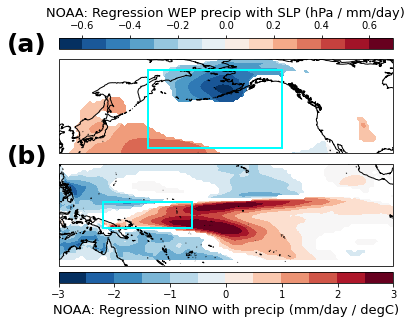

In [119]:

fig = plt.figure(figsize=(6,4.5))
# clon=-105
clon=180

widths = [1]; heights = [0.1, 1, 1, 0.1];
spec = fig.add_gridspec(ncols=1, nrows=4, width_ratios=widths, height_ratios=heights, wspace=0.1, hspace=0.1)

regr_unit = 'hPa / mm/day'
levels1 = np.arange(-0.7, 0.7+0.1, 0.1)
x = prwep_slp_regr_obs

cmap=plt.cm.RdBu_r
ax = fig.add_subplot(spec[1,0], projection=ccrs.PlateCarree(central_longitude=clon))
x.regr.where(x.pval<0.05).plot.contourf(ax=ax, levels = levels1, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(); 
ax.set_extent([120, 270, 28, 70], crs=ccrs.PlateCarree())
ax.set_title('')

ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'cyan', facecolor = 'none', lw=2, transform=ccrs.PlateCarree(), zorder=2))

ax.text(-83, 73, '(a)', fontsize = 25, fontweight = 'bold')

ax = fig.add_subplot(spec[0,0])
norm = matplotlib.colors.BoundaryNorm(levels1, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal'); 
ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
cbar.set_label(f'NOAA: Regression WEP precip with SLP ({regr_unit})', fontsize=13); 


####################################################################

regr_unit = 'mm/day / degC'
levels2 = np.arange(-3, 3+0.5, 0.5)
x = nino_prect_regr_obs

ax = fig.add_subplot(spec[2,0], projection=ccrs.PlateCarree(central_longitude=clon))
x.regr.where(x.pval<0.05).plot.contourf(ax=ax, levels = levels2, cmap = cmap, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.coastlines(); 
ax.set_extent([120, 270, -23, 23], crs=ccrs.PlateCarree())
ax.set_title('')

ax.add_patch(Rectangle((140,-6),40,12, edgecolor='cyan', facecolor='none', lw = 2, transform=ccrs.PlateCarree(), zorder=2))

ax.text(-83, 23, '(b)', fontsize = 25, fontweight = 'bold')

ax = fig.add_subplot(spec[3,0])
norm = matplotlib.colors.BoundaryNorm(levels2, cmap.N)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal'); 
cbar.set_label(f'NOAA: Regression NINO with precip ({regr_unit})', fontsize=13); 

#############################################################


plt.savefig('figures/supplement/NOAA_nino_prect_slp_regressions.png', dpi=300)

# plt.suptitle('hallo')

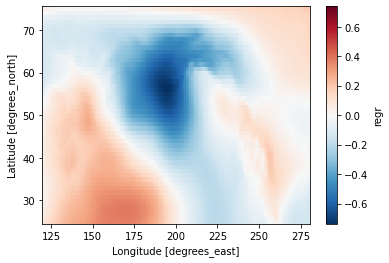

In [116]:
prwep_slp_regr_obs.regr.plot()

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


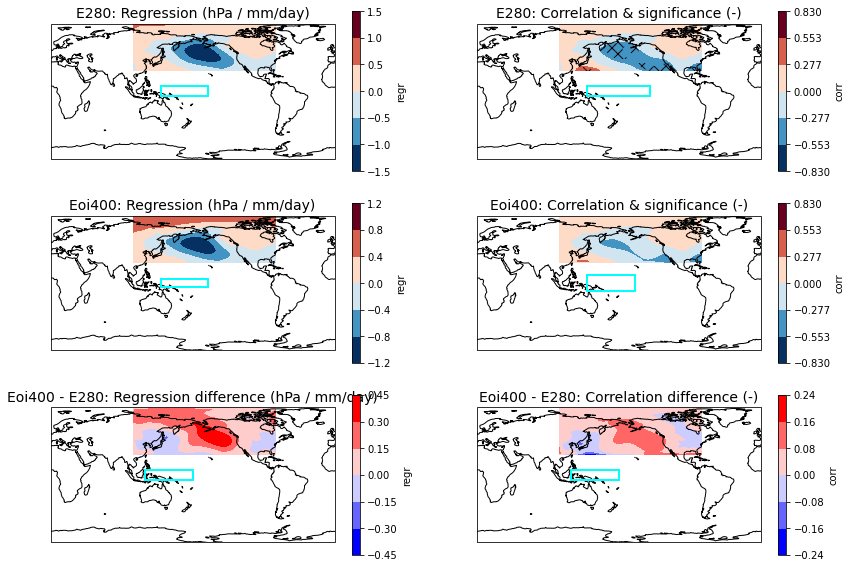

In [1094]:
# variable?
# data = nino_prect_regr.isel(model=idx).mean("model")
# regr_unit = 'mm/day / degC'
data = prwep_slp_regr.isel(model=idx).mean("model")
regr_unit = 'hPa / mm/day'


vmax1 = 0.83;

fig = plt.figure(figsize=(14,10))
# clon=-105
clon=180

ax = fig.add_subplot(321, projection=ccrs.PlateCarree(central_longitude=clon))
data.regr.sel(sim=sim1).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(); 
# ax.set_extent([120, 280, -20, 70], crs=ccrs.PlateCarree())
ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
ax.set_title(f"E280: Regression ({regr_unit})", fontsize=14)

ax.add_patch(Rectangle((140,-6),60,12, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))


ax = fig.add_subplot(322, projection=ccrs.PlateCarree(central_longitude=clon))
data.corr.sel(sim=sim1).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-vmax1, vmax=vmax1, cmap='RdBu_r')
data.pval.sel(sim=sim1).where(data.pval.sel(sim=sim1)<0.05).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), hatches = ['xx'], colors='None', add_colorbar=False)
ax.coastlines(); 
# ax.set_extent([120, 280, -20, 70], crs=ccrs.PlateCarree())
ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
ax.add_patch(Rectangle((140,-6),80,12, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

ax.set_title("E280: Correlation & significance (-)", fontsize=14)

# ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'magenta', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))


ax = fig.add_subplot(323, projection=ccrs.PlateCarree(central_longitude=clon))
data.regr.sel(sim=sim2).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines(); 
# ax.set_extent([120, 280, -20, 70], crs=ccrs.PlateCarree())
ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
ax.add_patch(Rectangle((140,-5),60,10, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

ax.set_title(f"Eoi400: Regression ({regr_unit})", fontsize=14)

# ax.add_patch(Rectangle((160, 30), 60, 35, edgecolor = 'magenta', facecolor = 'none', fill=False, lw=2, transform=ccrs.PlateCarree(), zorder=3))


ax = fig.add_subplot(324, projection=ccrs.PlateCarree(central_longitude=clon))
data.corr.sel(sim=sim2).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-vmax1, vmax=vmax1, cmap='RdBu_r')
data.pval.sel(sim=sim2).where(data.pval.sel(sim=sim2)<0.05).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), hatches = ['xx'], colors='None', add_colorbar=False)
ax.coastlines(); 
# ax.set_extent([120, 280, -20, 70], crs=ccrs.PlateCarree())
ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
ax.set_title("Eoi400: Correlation & significance (-)", fontsize=14)

ax.add_patch(Rectangle((140,-10),60,20, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))


ax = fig.add_subplot(325, projection=ccrs.PlateCarree(central_longitude=clon))
(data.regr.sel(sim=sim2) - data.regr.sel(sim=sim1)).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr')
ax.coastlines(); 
# ax.set_extent([120, 280, -20, 70], crs=ccrs.PlateCarree())
ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
ax.set_title(f"Eoi400 - E280: Regression difference ({regr_unit})", fontsize=14)

ax.add_patch(Rectangle((120,-6),60,12, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))


ax = fig.add_subplot(326, projection=ccrs.PlateCarree(central_longitude=clon))
(data.corr.sel(sim=sim2) - data.corr.sel(sim=sim1)).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cmap='bwr')
ax.coastlines(); 
# ax.set_extent([120, 280, -20, 70], crs=ccrs.PlateCarree())
ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
ax.set_title("Eoi400 - E280: Correlation difference (-)", fontsize=14)

ax.add_patch(Rectangle((120,-6),60,12, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

# plt.savefig('figures/Ensemblemean_regr_corr_DJFnino_DJFMslp_global.png', dpi=300)

# plt.suptitle('hallo')

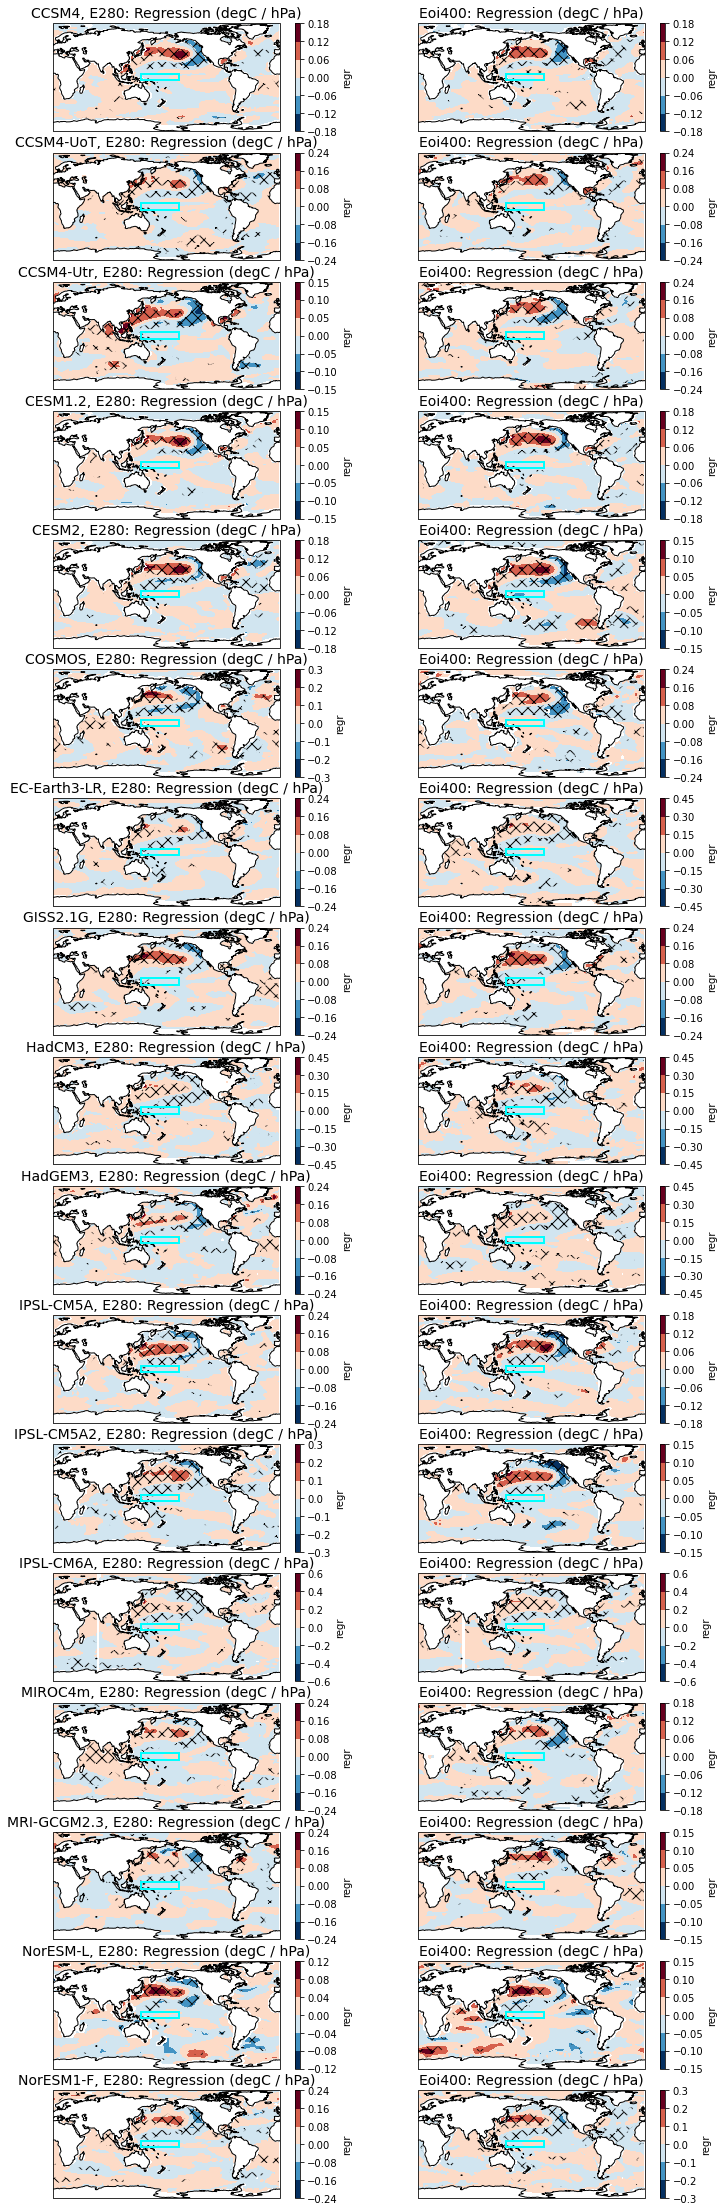

In [629]:
#### variable?
# data = nino_prect;
# data = prwep_slp;
data = ali_res_sst;

# regr_unit = 'hPa/degC'
# regr_unit = 'mm/day/degC'
# regr_unit = 'hPa/mm/day'
regr_unit = 'degC / hPa'

vmax1 = 0.83;

fig = plt.figure(figsize=(12,40))
# clon=-105
clon=180
N = len(modellist)

for i in range(len(modellist)):
    model = modellist[i]

    ax = fig.add_subplot(N, 2, 2*i+1, projection=ccrs.PlateCarree(central_longitude=clon))
    data.isel(model=i).regr.sel(sim=sim1).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
    data.isel(model=i).pval.sel(sim=sim1).where(data.isel(model=i).pval.sel(sim=sim1)<0.05).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), hatches = ['xx'], colors='None', add_colorbar=False)
    ax.coastlines(); 
    ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
    ax.add_patch(Rectangle((140,-5),60,10, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

    ax.set_title(f"{model}, E280: Regression ({regr_unit})", fontsize=14)


    ax = fig.add_subplot(N, 2, 2*i+2, projection=ccrs.PlateCarree(central_longitude=clon))
    data.isel(model=i).regr.sel(sim=sim2).plot.contourf(ax=ax, transform=ccrs.PlateCarree())
    data.isel(model=i).pval.sel(sim=sim2).where(data.isel(model=i).pval.sel(sim=sim2)<0.05).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), hatches = ['xx'], colors='None', add_colorbar=False)
    ax.coastlines(); 
    ax.set_extent([1, 359, -85, 85], crs=ccrs.PlateCarree())
    ax.add_patch(Rectangle((140,-5),60,10, linewidth=2, edgecolor='cyan',facecolor='none',zorder = 2, transform=ccrs.PlateCarree()))

    ax.set_title(f"Eoi400: Regression ({regr_unit})", fontsize=14)



Text(0.5, 0.98, 'Change in S.D. of PDO PC (Eoi400 - E280)')

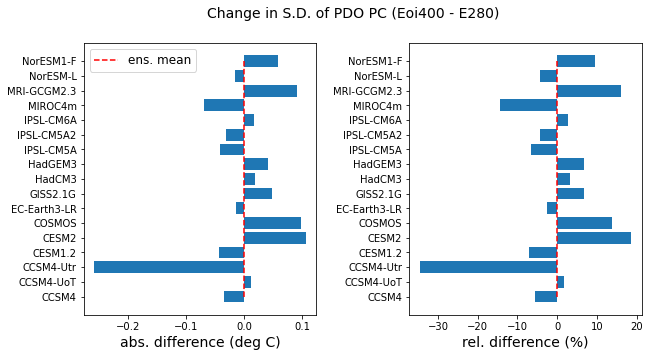

In [782]:
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(121)

diff = pdo_an_pc.std("time").sel(sim=sim2) - pdo_an_pc.std("time").sel(sim=sim1)
ax.barh(modellist, diff)
ax.set_xlabel("abs. difference (deg C)", fontsize = 14)
ax.plot([diff.mean(), diff.mean()], [modellist[0], modellist[-1]], 'r--', label = 'ens. mean')
ax.legend(fontsize = 12)

ax = fig.add_subplot(122)

diff = 100*(pdo_an_pc.std("time").sel(sim=sim2) - pdo_an_pc.std("time").sel(sim=sim1))/pdo_an_pc.std("time").sel(sim=sim1)
ax.barh(modellist, diff)
ax.set_xlabel("rel. difference (%)", fontsize = 14)
ax.plot([diff.mean(), diff.mean()], [modellist[0], modellist[-1]], 'r--', label = 'ens. mean')
# ax.legend(fontsize = 14)

fig.subplots_adjust(wspace=0.4)
plt.suptitle('Change in S.D. of PDO PC (Eoi400 - E280)', fontsize = 14)

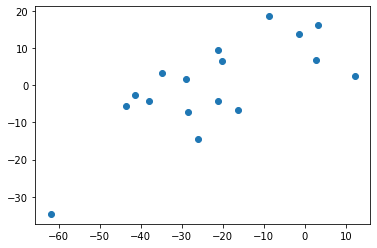

In [785]:
ds = xr.open_dataset('PlioMIP2 data/PlioMIP2_NINO_ALI_indices.nc')
nino = ds.nino

d_nino = 100 * (nino.sel(sim=sim2).std("time") - nino.sel(sim=sim1).std("time")) / nino.sel(sim=sim1).std("time")
d_pdo = 100*(pdo_an_pc.std("time").sel(sim=sim2) - pdo_an_pc.std("time").sel(sim=sim1))/pdo_an_pc.std("time").sel(sim=sim1)

plt.scatter(d_nino, d_pdo)

In [744]:
# Select model and simulations

da_1 = 0. * ali_djfm;
da_2 = 0. * ali_djfm;
da_3 = 0. * ali_djfm;

for j in range(len(simlist)):
    
    sim = simlist[j]

    for i in range(len(modellist)):

        model = modellist[i]

        nino = nino_djf.sel(sim=sim).sel(model=model)
        ali  = ali_djfm.sel(sim=sim).sel(model=model)
        pdo  = pdo_fma_pc.sel(sim=sim).sel(model=model)
        
        # split following linear regression model
        regr_nino = compute_regression(nino, pdo, dim = "time")
        if regr_nino.pval < 0.05:
            pdo_nino = regr_nino.regr * nino;
        else:
            pdo_nino = 0. * nino;
        regr_ali = compute_regression(ali, pdo, dim = "time")
        if regr_ali.pval < 0.05:
            pdo_ali = regr_ali.regr * ali;
        else:
            pdo_ali = 0. * ali;
            
        pdo_res = pdo - pdo_nino - pdo_ali; 
        
        da_1[j,i,:] = pdo_nino;
        da_2[j,i,:] = pdo_ali;
        da_3[j,i,:] = pdo_res;
               
da = da_1.to_dataset(name = "nino")
da["ali"] = da_2
da["res"] = da_3

da.nino.attrs["units"] = 'degC'
da.nino.attrs["description"] = 'PDO regressing with DJF Nino'
da.ali.attrs["units"] = 'degC'
da.ali.attrs["description"] = 'PDO regressing with DJFM ALI'
da.res.attrs["units"] = 'degC'
da.res.attrs["description"] = 'PDO residual (minus Nino part)'
da.attrs["description"] = 'FMA PDO split in Nino regressing, ALI regressing and residual'

# save ALI LRM = linear regression model
pdo_lrm = da;

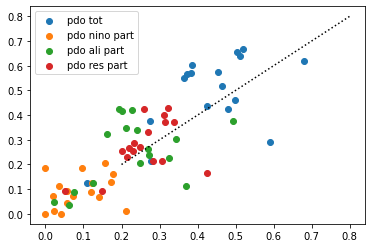

In [751]:

a = pdo_fma_pc.sel(sim=sim1).var("time")
b = pdo_fma_pc.sel(sim=sim2).var("time")

plt.scatter(a,b, label = 'pdo tot')

a = pdo_lrm.nino.sel(sim=sim1).var("time")
b = pdo_lrm.nino.sel(sim=sim2).var("time")

plt.scatter(a,b, label = 'pdo nino part')

a = pdo_lrm.ali.sel(sim=sim1).var("time")
b = pdo_lrm.ali.sel(sim=sim2).var("time")

plt.scatter(a,b, label = 'pdo ali part')

a = pdo_lrm.res.sel(sim=sim1).var("time")
b = pdo_lrm.res.sel(sim=sim2).var("time")

plt.scatter(a,b, label = 'pdo res part')

plt.plot([0.2,0.8], [0.2,0.8], 'k:')
plt.legend()

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den


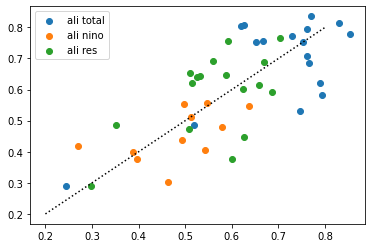

In [729]:

stat = compute_regression(ali_djfm, pdo_fma_pc, dim = "time")
a = stat.corr.where(stat.pval<0.05).sel(sim=sim1)
b = stat.corr.where(stat.pval<0.05).sel(sim=sim2)

plt.scatter(a,b, label = 'ali total')

stat = compute_regression(ali_lrm.nino, pdo_fma_pc, dim = "time")
a = stat.corr.where(stat.pval<0.05).sel(sim=sim1)
b = stat.corr.where(stat.pval<0.05).sel(sim=sim2)

plt.scatter(a,b, label = 'ali nino')

stat = compute_regression(ali_lrm.res, pdo_fma_pc, dim = "time")
a = stat.corr.where(stat.pval<0.05).sel(sim=sim1)
b = stat.corr.where(stat.pval<0.05).sel(sim=sim2)

plt.scatter(a,b, label = 'ali res')

plt.plot([0.2,0.8], [0.2,0.8], 'k:')
plt.legend()

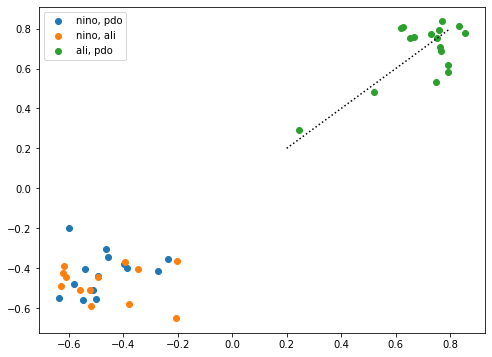

In [742]:

plt.figure(figsize = (8,6))

stat = compute_regression(nino_djf, pdo_fma_pc, dim = "time")
a = stat.corr.where(stat.pval<0.05).sel(sim=sim1)
b = stat.corr.where(stat.pval<0.05).sel(sim=sim2)

plt.scatter(a,b, label = 'nino, pdo')

stat = compute_regression(nino_djf, ali_djfm, dim = "time")
a = stat.corr.where(stat.pval<0.05).sel(sim=sim1)
b = stat.corr.where(stat.pval<0.05).sel(sim=sim2)

plt.scatter(a,b, label = 'nino, ali')

stat = compute_regression(ali_djfm, pdo_fma_pc, dim = "time")
a = stat.corr.where(stat.pval<0.05).sel(sim=sim1)
b = stat.corr.where(stat.pval<0.05).sel(sim=sim2)

plt.scatter(a,b, label = 'ali, pdo')

plt.plot([0.2,0.8], [0.2,0.8], 'k:')
plt.legend()

In [734]:
ds = xr.open_dataset('PlioMIP2 data/PlioMIP2_NINO_ALI_indices.nc')

i = 2

# model = "CCSM4-Utr"; 
model = modellist[i]
sim = sim1

# var1 = ds.sel(model = model, sim = sim).ali;
# var1 = ds.sel(model = model, sim = sim).nino;
# var2 = PDO_PC.sel(model = model, sim = sim)

var1 = ali_obs
var2 = pdo_obs


LL, LL_p = lead_lag(var1, var2, model, sim)

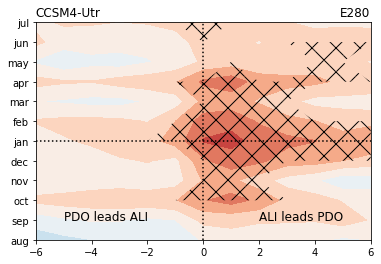

In [735]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(LL.lag, LL.month, LL, cmap='RdBu_r', vmin=-1, vmax=1)
ax.contourf(LL.lag, LL.month, LL_p.where(LL_p<0.05), hatches = ['x'], colors='None')

# ax.contour(LL.lag, LL.month, LL, levels = [-.35], colors=['r'], linestyles = ['--'])

ax.plot([0, 0], ["aug", "jul"],  'k:')
ax.plot([-6, 6], ["jan", "jan"], 'k:')

# LL_min = LL.where(LL==LL.max(), drop=True).squeeze()
# ax.plot(LL_min.lag, LL_min.month, 'r*', markersize=15)
# ax.text((LL_min.lag+0.4), (LL_min.month), np.round(LL_min.values,2), fontsize = 12, color='w', fontweight='bold')

# ax.text(-5, "sep", "NINO leads ALI", fontsize = 12); ax.text(2, "sep", "ALI leads NINO", fontsize = 12)
ax.text(-5, "sep", "PDO leads ALI", fontsize = 12); ax.text(2, "sep", "ALI leads PDO", fontsize = 12)

ax.set_title(model, loc='left'); ax.set_title(sim, loc='right');

In [793]:
# d_pdo = PDO_fma_SD.sel(sim=sim2) - PDO_fma_SD.sel(sim=sim1)
d_pdo = pdo_fma_pc.sel(sim=sim2).std("time") - pdo_fma_pc.sel(sim=sim1).std("time")
d_pdo_nino = pdo_lrm.nino.sel(sim=sim2).std("time") - pdo_lrm.nino.sel(sim=sim1).std("time")
d_pdo_ali = pdo_lrm.ali.sel(sim=sim2).std("time") - pdo_lrm.ali.sel(sim=sim1).std("time")

d_nino = nino_djf.sel(sim=sim2).std("time") - nino_djf.sel(sim=sim1).std("time")
d_ali = ali_djfm.sel(sim=sim2).std("time") - ali_djfm.sel(sim=sim1).std("time")

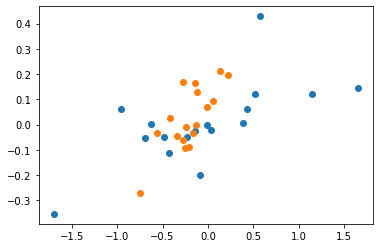

In [794]:
plt.scatter(d_ali, d_pdo_nino)
plt.scatter(d_nino, d_pdo_ali)

In [798]:
# xs.pearson_r(d_nino,d_pdo_ali)
# xs.pearson_r(d_ali,d_pdo_nino)

<xarray.DataArray ()>
array(0.75724812)


## PDO amplitude ...?

<BarContainer object of 17 artists>

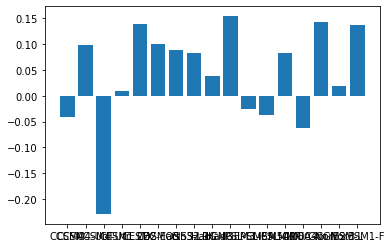

In [740]:
plt.bar(modellist, d_pdo)

In [15]:
d_ip_sst

NameError: name 'd_ip_sst' is not defined

In [33]:

x1 = compute_regression(nino_djf.sel(sim=sim1), prwep_djf.sel(sim=sim1))
x2 = compute_regression(nino_djf.sel(sim=sim2), prwep_djf.sel(sim=sim2))
y1 = compute_regression(prwep_djf.sel(sim=sim1), ali_djfm.sel(sim=sim1))
y2 = compute_regression(prwep_djf.sel(sim=sim2), ali_djfm.sel(sim=sim2))

d_nino_pr_regr = x2.regr - x1.regr
d_pr_ali_regr  = y2.regr - y1.regr

## try out some comparisons with literature

In [43]:
d_ali   = ali_djfm.sel(sim=sim2).std("time")  - ali_djfm.sel(sim=sim1).std("time")
d_nino  = nino_djf.sel(sim=sim2).std("time")  - nino_djf.sel(sim=sim1).std("time")
d_prwep = prwep_djf.sel(sim=sim2).std("time") - prwep_djf.sel(sim=sim1).std("time")

d_pwc_int = lit_data.d_pwc_int
d_pwc_lon = lit_data.d_pwc_lon
d_wpwind  = lit_data.d_djf_wpwind
d_pitcz   = lit_data.d_djf_pitcz
d_mc_sst  = lit_data.d_mc_sst


## Nino_djf vs ensemble changes

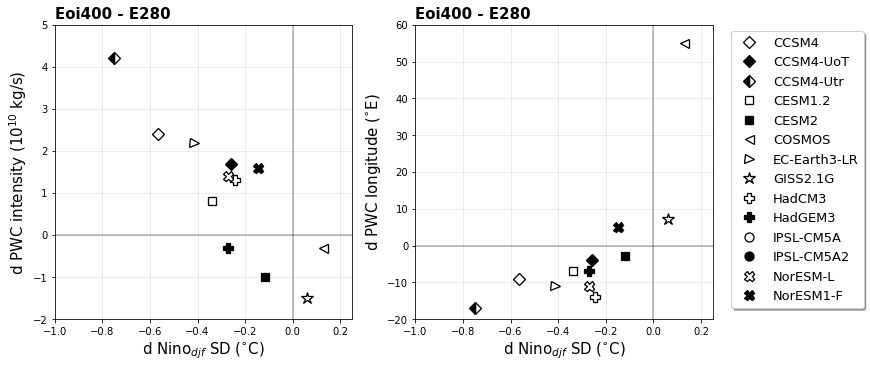

In [35]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-1, 0.25]; ylims = [-2, 5];

ax = fig.add_subplot(spec[0])

x = d_nino
y = d_pwc_int

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd PWC intensity (10$^{10}$ kg/s)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-1, 0.25]; ylims = [-20, 60];

ax = fig.add_subplot(spec[1])

x = d_nino
y = d_pwc_lon

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd PWC longitude ($^{\circ}$E)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


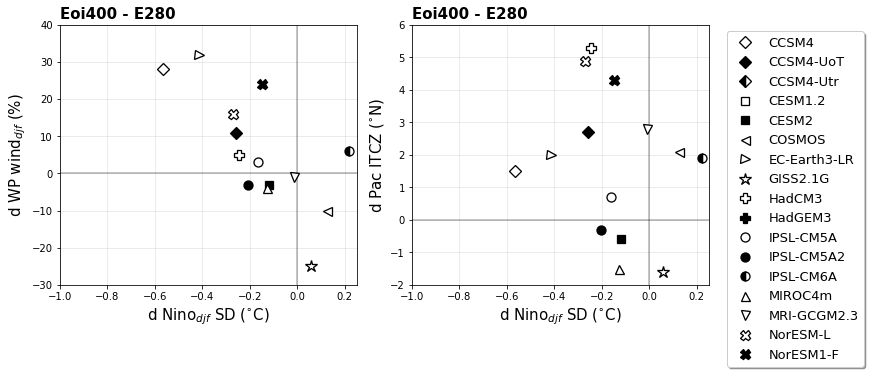

In [616]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-1, 0.25]; ylims = [-30, 40];

ax = fig.add_subplot(spec[0])

x = d_nino
y = d_wpwind

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd WP wind$_{djf}$ (%)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-1, 0.25]; ylims = [-2, 6];

ax = fig.add_subplot(spec[1])

x = d_nino
y = d_pitcz

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel(r'd Pac ITCZ ($^{\circ}$N)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


# ALI_djfm vs ensemble changes

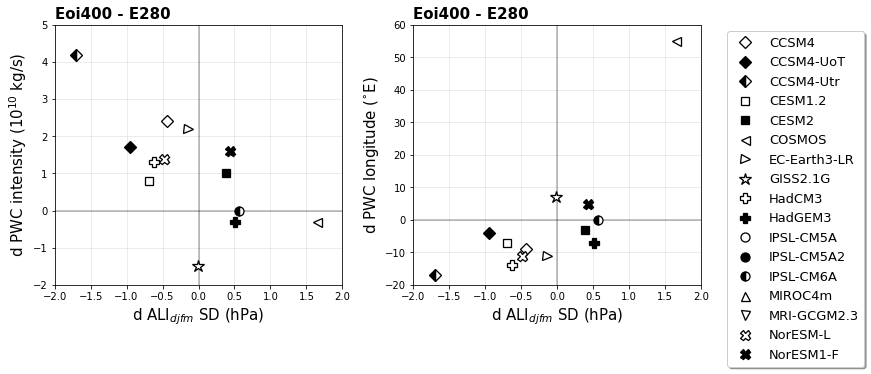

In [618]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-2, 2]; ylims = [-2, 5];

ax = fig.add_subplot(spec[0])

x = d_ali
y = d_pwc_int

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd ALI$_{djfm}$ SD (hPa)', fontsize=15);
ax.set_ylabel(r'd PWC intensity (10$^{10}$ kg/s)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-2, 2]; ylims = [-20, 60];

ax = fig.add_subplot(spec[1])

x = d_ali
y = d_pwc_lon

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd ALI$_{djfm}$ SD (hPa)', fontsize=15);
ax.set_ylabel(r'd PWC longitude ($^{\circ}$E)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


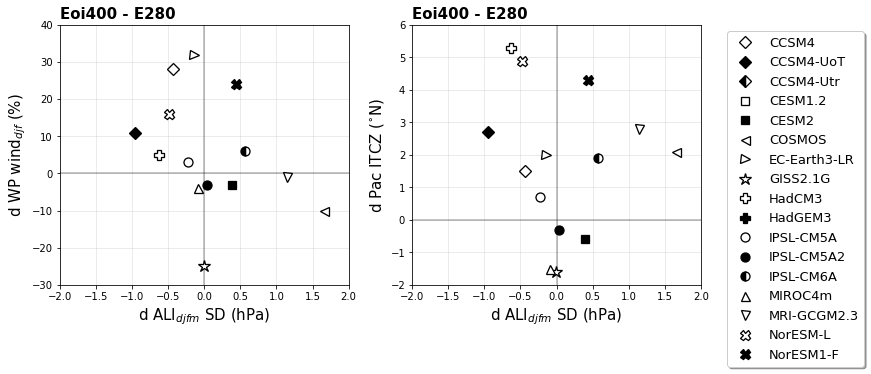

In [619]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-2,2]; ylims = [-30, 40];

ax = fig.add_subplot(spec[0])

x = d_ali
y = d_wpwind

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd ALI$_{djfm}$ SD (hPa)', fontsize=15);
ax.set_ylabel(r'd WP wind$_{djf}$ (%)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-2,2]; ylims = [-2, 6];

ax = fig.add_subplot(spec[1])

x = d_ali
y = d_pitcz

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd ALI$_{djfm}$ SD (hPa)', fontsize=15);
ax.set_ylabel(r'd Pac ITCZ ($^{\circ}$N)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


## WEP precip_djf vs ensemble 

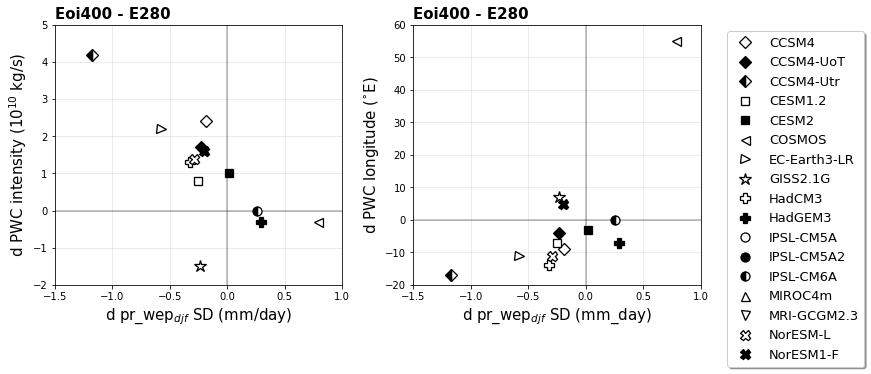

In [620]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-1.5, 1]; ylims = [-2, 5];

ax = fig.add_subplot(spec[0])

x = d_prwep
y = d_pwc_int

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm/day)', fontsize=15);
ax.set_ylabel(r'd PWC intensity (10$^{10}$ kg/s)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-1.5, 1]; ylims = [-20, 60];

ax = fig.add_subplot(spec[1])

x = d_prwep
y = d_pwc_lon

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm_day)', fontsize=15);
ax.set_ylabel(r'd PWC longitude ($^{\circ}$E)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


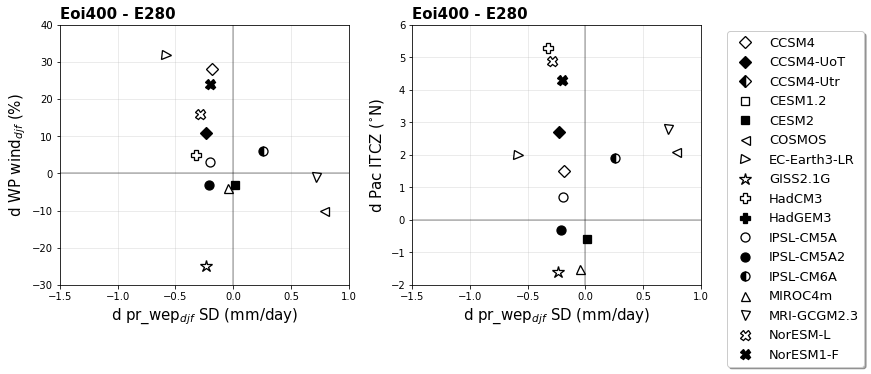

In [621]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-1.5, 1]; ylims = [-30, 40];

ax = fig.add_subplot(spec[0])

x = d_prwep
y = d_wpwind

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm/day)', fontsize=15);
ax.set_ylabel(r'd WP wind$_{djf}$ (%)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-1.5, 1]; ylims = [-2, 6];

ax = fig.add_subplot(spec[1])

x = d_prwep
y = d_pitcz

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
#     if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm/day)', fontsize=15);
ax.set_ylabel(r'd Pac ITCZ ($^{\circ}$N)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


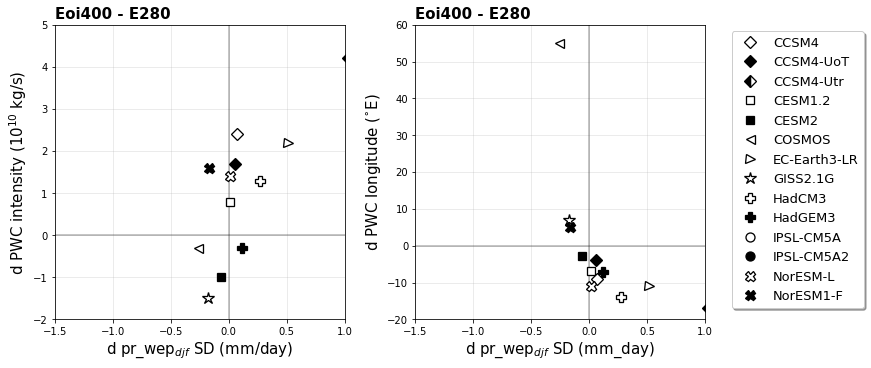

In [38]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-1.5, 1]; ylims = [-2, 5];

ax = fig.add_subplot(spec[0])

# x = d_nino_pr_regr
x = d_pr_ali_regr
y = d_pwc_int

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm/day)', fontsize=15);
ax.set_ylabel(r'd PWC intensity (10$^{10}$ kg/s)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-1.5, 1]; ylims = [-20, 60];

ax = fig.add_subplot(spec[1])

# x = d_nino_pr_regr
x = d_pr_ali_regr
y = d_pwc_lon

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm_day)', fontsize=15);
ax.set_ylabel(r'd PWC longitude ($^{\circ}$E)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


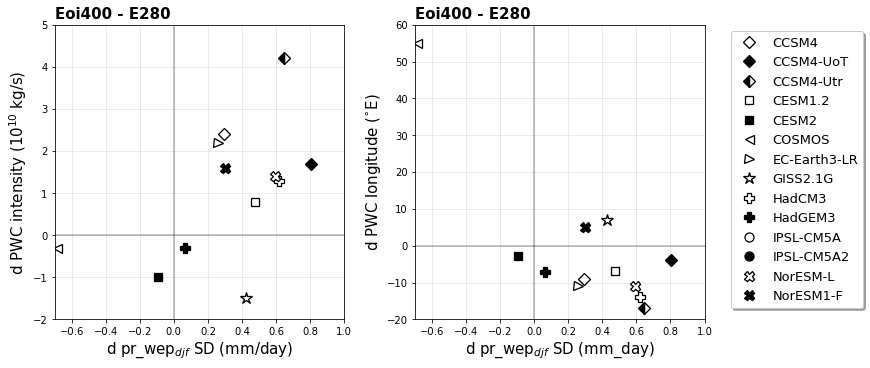

In [90]:
fig = plt.figure(figsize=(12,5), constrained_layout=True)
widths = [1, 1, 0.3]; heights = [1];
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths, height_ratios=heights)

#############################################################

xlims = [-0.7,1]; ylims = [-2, 5];

ax = fig.add_subplot(spec[0])

# x = d_mc_sst
# x = d_ip_sst
x = d_indopac
y = d_pwc_int

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

h, l = ax.get_legend_handles_labels() 
ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm/day)', fontsize=15);
ax.set_ylabel(r'd PWC intensity (10$^{10}$ kg/s)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

xlims = [-0.7, 1]; ylims = [-20, 60];

ax = fig.add_subplot(spec[1])

# x = d_nino_pr_regr
# x = d_mc_sst
# x = d_ip_sst
x = d_indopac
y = d_pwc_lon

ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)
ax.set_xlim(xlims); ax.set_ylim(ylims);

# plot model values
for i in range(len(modellist)):
    if i in idx:
        ax.plot(x[i], y[i], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.3)
# ax.plot(x.isel(model=idx).mean(), y.isel(model=idx).mean(), marker = 'v', color='w', markeredgecolor='red', markeredgewidth=2,
#         linestyle='None', markersize = 15, label='MMM')

ax.set_xlabel(r'd pr_wep$_{djf}$ SD (mm_day)', fontsize=15);
ax.set_ylabel(r'd PWC longitude ($^{\circ}$E)', fontsize=15)
ax.set_title("Eoi400 - E280", fontsize=15, loc='left', fontweight='bold')
ax.grid(alpha=0.3)

# x = x.isel(model=idx); y = y.isel(model=idx);
# polyfit = np.polyfit(x,y,deg=1)
# x_ = np.array([x.min(), x.max()]);
# y_ = np.polyval(polyfit, x_)
# ax.plot(x_, y_, 'r--',zorder=-1)

# corr =  xs.pearson_r(x, y, dim='model').values
# ax.text(-0.7, 1.3, f"corr: {np.round(corr,2)}", fontsize=15, fontweight='bold' ,color='r')

#############################################################

ax = fig.add_subplot(spec[2])
ax.legend(h,l, loc='upper left', shadow=True, ncol=1, fontsize=13)
ax.set_axis_off()



# plt.savefig('figures/d_djf_nino_d_djfm_ali.png',dpi=300)


In [24]:
d_pwc_lon

array([ -9. ,  -3.8, -16.9,  -6.8,  -2.9,  55. , -10.9,   7.1, -14. ,
        -7. ,   nan,   nan,   0.2,   nan,   nan, -11. ,   5. ])

In [105]:
x[y.notnull()]

<xarray.DataArray 'sst' (model: 13)>
array([ 0.232553  ,  0.56960438,  0.74589435,  0.34700988,  0.12416442,
       -0.54564823,  0.44950594,  0.27778532,  0.62327761,  0.08500426,
        0.17638617,  0.73759457,  0.31285232])
Coordinates:
  * model    (model) <U12 'CCSM4' 'CCSM4-UoT' ... 'NorESM-L' 'NorESM1-F'

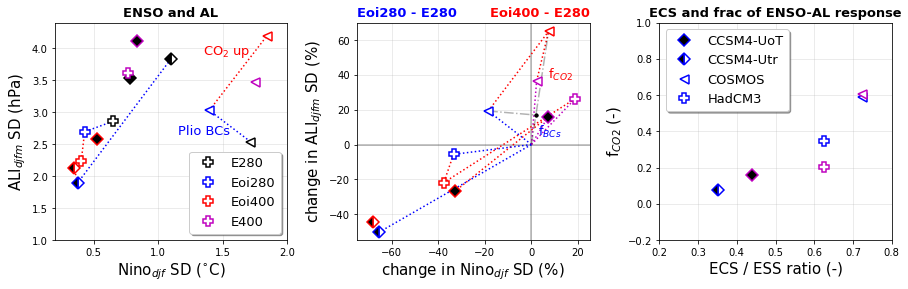

In [144]:
x1 = nino_sd.sel(sim=sim1); x2 = nino_sd.sel(sim=sim2); x3 = nino_sd.sel(sim=sim3); x4 = nino_sd.sel(sim=sim4);
y1 = ali_sd.sel(sim=sim1);  y2 = ali_sd.sel(sim=sim2);  y3 = ali_sd.sel(sim=sim3); y4 = ali_sd.sel(sim=sim4);

fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(131)

xlims = [0.2, 2.0]; ylims = [1.0, 4.4];
ax.set_xlim(xlims); ax.set_ylim(ylims);

for i in range(len(idx_sens)):
    ax.plot([x1[i], x3[i]], [y1[i], y3[i]], 'b:')
    ax.plot([x3[i], x2[i]], [y3[i], y2[i]], 'r:')
    
for j in range(len(idx_sens)):
    i = idx_sens[j];
    p1, = ax.plot(x1[j], y1[j], label = sim1, marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    p2, = ax.plot(x2[j], y2[j], label = sim2, marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'r', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    p3, = ax.plot(x3[j], y3[j], label = sim3, marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'b', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    p4, = ax.plot(x4[j], y4[j], label = sim4, marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'm', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)

ax.legend(handles=[p1,p3,p2,p4], loc='lower right', shadow=True, ncol=1, fontsize=13)
    
ax.text(1.15, 2.65, 'Plio BCs', fontsize = 13, color = 'b')
ax.text(1.35, 3.9, r'CO$_2$ up', fontsize = 13, color = 'r')
    
ax.set_xlabel('Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel('ALI$_{djfm}$ SD (hPa)', fontsize=15)
ax.set_title("ENSO and AL", fontsize=13, loc='center', fontweight='bold')
ax.grid(alpha=0.3)
    
ax = fig.add_subplot(132)

xlims = [-75, 25]; ylims = [-55, 70];
ax.set_xlim(xlims); ax.set_ylim(ylims);
ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)

for j in range(len(idx_sens)):
    ax.plot([0, 100*(x3[j]-x1[j])/x1[j]], [0, 100*(y3[j]-y1[j])/y1[j]], 'b:')
    ax.plot([100*(x3[j]-x1[j])/x1[j], 100*(x2[j]-x1[j])/x1[j]], [100*(y3[j]-y1[j])/y1[j], 100*(y2[j]-y1[j])/y1[j]], 'r:')
    ax.plot([0, 100*(x4[j]-x1[j])/x1[j]], [0, 100*(y4[j]-y1[j])/y1[j]], 'm:')
    ax.plot([100*(x4[j]-x1[j])/x1[j], 100*(x2[j]-x1[j])/x1[j]], [100*(y4[j]-y1[j])/y1[j], 100*(y2[j]-y1[j])/y1[j]], 'r:')

i = 2;
px_ = 100*(x2[i]-x1[i])/x1[i]; py_ = 100*(y2[i]-y1[i])/y1[i]; pf_ = f3_bc[i];
px_3 = 100*(x3[i]-x1[i])/x1[i]; py_3 = 100*(y3[i]-y1[i])/y1[i]; 
ax.plot([0, px_], [0, py_], 'k-.', alpha =0.3)
ax.plot([px_3, pf_*px_], [py_3, pf_*py_], 'k-.', alpha =0.3)
ax.plot([pf_*px_, pf_*px_], [pf_*py_, pf_*py_], 'k.')

# plot model values
for j in range(len(idx_sens)):
    i = idx_sens[j];
    ax.plot(100*(x2[j]-x1[j])/x1[j], 100*(y2[j]-y1[j])/y1[j], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'r', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    ax.plot(100*(x3[j]-x1[j])/x1[j], 100*(y3[j]-y1[j])/y1[j], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'b', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    ax.plot(100*(x4[j]-x1[j])/x1[j], 100*(y4[j]-y1[j])/y1[j], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'm', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)

ax.text(7, 38, r'f$_{CO2}$', color = 'r', fontsize = 13)
ax.text(3, 5, r'f$_{BCs}$', color = 'b', fontsize = 13)

ax.set_xlabel('change in Nino$_{djf}$ SD (%)', fontsize=15);
ax.set_ylabel('change in ALI$_{djfm}$ SD (%)', fontsize=15)
ax.set_title("Eoi280 - E280", fontsize=13, loc='left', fontweight='bold', color='b')
ax.set_title("Eoi400 - E280", fontsize=13, loc='right', fontweight='bold', color='r')
ax.grid(alpha=0.3)


ax = fig.add_subplot(133)

xlims = [0.2, 0.8]; ylims = [-.2, 1.];
ax.set_xlim(xlims); ax.set_ylim(ylims);

x = (ecs/ess).isel(model=idx_sens)
# y1 = np.abs(f3_co2); y2 = np.abs(f4_co2);
y1 = f3_bcs; y2 = f4_bcs;

    
for j in range(len(idx_sens)):
    i = idx_sens[j];
    p1, = ax.plot(x[j], y1[j], label = modellist_sens[j], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'b', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    _, = ax.plot(x[j], y2[j], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'm', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)

ax.legend(loc='upper left', shadow=True, ncol=1, fontsize=13)

ax.set_xlabel('ECS / ESS ratio (-)', fontsize=15);
ax.set_ylabel(r'f$_{CO2}$ (-)', fontsize=15)
ax.set_title("ECS and frac of ENSO-AL response", fontsize=13, loc='center', fontweight='bold', color='k')
ax.grid(alpha=0.3)

plt.subplots_adjust(wspace=0.3)


# plt.savefig('figures/enso_al_sensitivity_ECS.png',dpi=300)


In [201]:
ess.isel(model=idx_sens)

<xarray.DataArray (model: 4)>
array([7.3, 9.1, 6.5, 5.6])
Coordinates:
  * model    (model) <U12 'CCSM4-UoT' 'CCSM4-Utr' 'COSMOS' 'HadCM3'

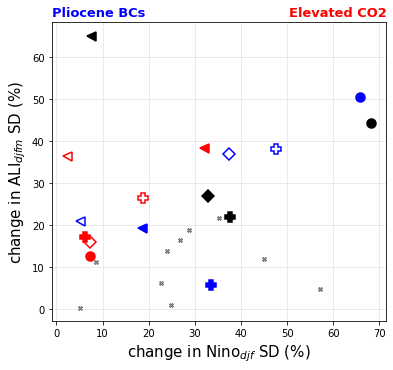

In [125]:
x1 = nino_sd.sel(sim=sim1); x2 = nino_sd.sel(sim=sim2); x3 = nino_sd.sel(sim=sim3); x4 = nino_sd.sel(sim=sim4);
y1 = ali_sd.sel(sim=sim1);  y2 = ali_sd.sel(sim=sim2);  y3 = ali_sd.sel(sim=sim3); y4 = ali_sd.sel(sim=sim4);

fig = plt.figure(figsize=(6,5.5))

ax = fig.add_subplot(111)

# xlims = [-75, 35]; ylims = [-55, 70];
# ax.set_xlim(xlims); ax.set_ylim(ylims);
# ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)


# ellipse = Ellipse((12, 17), 78, 32, angle=66, alpha=0.1, color='r')
# ax.add_artist(ellipse)

# ellipse = Ellipse((-32, -15), 107, 26, angle=47, alpha=0.1, color='b')
# ax.add_artist(ellipse)

x_ = np.abs( 100 * (nino_djf.sel(sim=sim2).std("time") - nino_djf.sel(sim=sim1).std("time"))/nino_djf.sel(sim=sim1).std("time"))
y_ = np.abs(100 * (ali_djfm.sel(sim=sim2).std("time") - ali_djfm.sel(sim=sim1).std("time"))/ali_djfm.sel(sim=sim1).std("time"))

for i in range(len(modellist)):
    for i in idx:
        if i not in idx_sens:
            ax.scatter(x_[i], y_[i], marker = 'x', s = 10, color = 'gray')

# plot model values
for j in range(len(idx_sens)):
    i = idx_sens[j];
    
    # full diff
    ax.plot(np.abs(100*(x2[j]-x1[j])/x1[j]), np.abs(100*(y2[j]-y1[j])/y1[j]), label = modellist[i], marker = markers_sens[j], markersize = msize_sens[j], 
            color='k', linestyle='None', markeredgecolor = 'k', fillstyle = 'full', markeredgewidth=1.5)
    
    # Plio BCs
    ax.plot(np.abs(100*(x3[j]-x1[j])/x1[j]), np.abs(100*(y3[j]-y1[j])/y1[j]), marker = markers_sens[j], markersize = msize_sens[j], 
            color='b', linestyle='None', markeredgecolor = 'b', fillstyle = 'full', markeredgewidth=1.5)
    ax.plot(np.abs(100*(x2[j]-x4[j])/x4[j]), np.abs(100*(y2[j]-y4[j])/y4[j]), marker = markers_sens[j], markersize = msize_sens[j], 
            color='w', linestyle='None', markeredgecolor = 'b', fillstyle = 'full', markeredgewidth=1.5)
    
    # CO2 effect
    ax.plot(np.abs(100*(x2[j]-x3[j])/x3[j]), np.abs(100*(y2[j]-y3[j])/y3[j]), marker = markers_sens[j], markersize = msize_sens[j], 
            color='r', linestyle='None', markeredgecolor = 'r', fillstyle = 'full', markeredgewidth=1.5)
    ax.plot(np.abs(100*(x4[j]-x1[j])/x1[j]), np.abs(100*(y4[j]-y1[j])/y1[j]), marker = markers_sens[j], markersize = msize_sens[j], 
            color='w', linestyle='None', markeredgecolor = 'r', fillstyle = 'full', markeredgewidth=1.5)
    
# ax.text(7, 38, r'f$_{CO2}$', color = 'r', fontsize = 13)
# ax.text(3, 5, r'f$_{BCs}$', color = 'b', fontsize = 13)

ax.set_xlabel('change in Nino$_{djf}$ SD (%)', fontsize=15);
ax.set_ylabel('change in ALI$_{djfm}$ SD (%)', fontsize=15)
ax.set_title("Pliocene BCs", fontsize=13, loc='left', fontweight='bold', color='b')
ax.set_title("Elevated CO2", fontsize=13, loc='right', fontweight='bold', color='r')
ax.grid(alpha=0.3)

# plt.savefig('figures/enso_al_sensitivity_ECS.png',dpi=300)


In [ ]:
x1 = nino_sd.sel(sim=sim1); x2 = nino_sd.sel(sim=sim2); x3 = nino_sd.sel(sim=sim3);
y1 = ali_sd.sel(sim=sim1);  y2 = ali_sd.sel(sim=sim2);  y3 = ali_sd.sel(sim=sim3);

fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(131)

xlims = [0.2, 2.0]; ylims = [1.6, 4.4];
ax.set_xlim(xlims); ax.set_ylim(ylims);

for i in range(len(idx_sens)):
    ax.plot([x1[i], x3[i]], [y1[i], y3[i]], 'b:')
    ax.plot([x3[i], x2[i]], [y3[i], y2[i]], 'r:')
    
for j in range(len(idx_sens)):
    i = idx_sens[j];
    p1, = ax.plot(x1[j], y1[j], label = sim1, marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    p2, = ax.plot(x2[j], y2[j], label = sim2, marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'r', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    p3, = ax.plot(x3[j], y3[j], label = sim3, marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'b', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)

ax.legend(handles=[p1,p3,p2], loc='upper left', shadow=True, ncol=1, fontsize=13)
    
ax.text(1.15, 2.65, 'Plio BCs', fontsize = 13, color = 'b')
ax.text(1.35, 3.9, r'CO$_2$ up', fontsize = 13, color = 'r')
    
ax.set_xlabel('Nino$_{djf}$ SD ($^{\circ}$C)', fontsize=15);
ax.set_ylabel('ALI$_{djfm}$ SD (hPa)', fontsize=15)
ax.set_title("ENSO and AL", fontsize=13, loc='center', fontweight='bold')
ax.grid(alpha=0.3)
    
ax = fig.add_subplot(132)

xlims = [-75, 20]; ylims = [-55, 70];
ax.set_xlim(xlims); ax.set_ylim(ylims);
ax.plot(xlims, [0,0], 'k-', alpha=0.3); ax.plot([0,0], ylims, 'k-', alpha=0.3)

for j in range(len(idx_sens)):
    ax.plot([0, 100*(x3[j]-x1[j])/x1[j]], [0, 100*(y3[j]-y1[j])/y1[j]], 'b:')
    ax.plot([100*(x3[j]-x1[j])/x1[j], 100*(x2[j]-x1[j])/x1[j]], [100*(y3[j]-y1[j])/y1[j], 100*(y2[j]-y1[j])/y1[j]], 'r:')

px_ = 100*(x2[1]-x1[1])/x1[1]; py_ = 100*(y2[1]-y1[1])/y1[1]; pf_ = f_bc[1];
px_3 = 100*(x3[1]-x1[1])/x1[1]; py_3 = 100*(y3[1]-y1[1])/y1[1]; 
ax.plot([0, px_], [0, py_], 'k-.', alpha =0.3)
ax.plot([px_3, pf_*px_], [py_3, pf_*py_], 'k-.', alpha =0.3)
ax.plot([pf_*px_, pf_*px_], [pf_*py_, pf_*py_], 'k.')

# plot model values
for j in range(len(idx_sens)):
    i = idx_sens[j];
    ax.plot(100*(x2[j]-x1[j])/x1[j], 100*(y2[j]-y1[j])/y1[j], label = modellist[i], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'r', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)
    ax.plot(100*(x3[j]-x1[j])/x1[j], 100*(y3[j]-y1[j])/y1[j], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'b', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)

ax.text(7, 38, r'f$_{CO2}$', color = 'r', fontsize = 13)
ax.text(3, 5, r'f$_{BCs}$', color = 'b', fontsize = 13)

ax.set_xlabel('change in Nino$_{djf}$ SD (%)', fontsize=15);
ax.set_ylabel('change in ALI$_{djfm}$ SD (%)', fontsize=15)
ax.set_title("Eoi280 - E280", fontsize=13, loc='left', fontweight='bold', color='b')
ax.set_title("Eoi400 - E280", fontsize=13, loc='right', fontweight='bold', color='r')
ax.grid(alpha=0.3)


ax = fig.add_subplot(133)

xlims = [0.2, 0.8]; ylims = [-0.2, 1.];
ax.set_xlim(xlims); ax.set_ylim(ylims);

x = (ecs/ess).isel(model=idx_sens)
y = f_co2
    
for j in range(len(idx_sens)):
    i = idx_sens[j];
    p1, = ax.plot(x[j], y[j], label = modellist_sens[j], marker = markers[i], markersize = msize[i], color=colors[i], linestyle='None', 
                markeredgecolor = 'k', fillstyle = fillstyles[i], markerfacecoloralt = 'k', markeredgewidth=1.5)

ax.legend(loc='upper left', shadow=True, ncol=1, fontsize=13)

ax.set_xlabel('ECS / ESS ratio (-)', fontsize=15);
ax.set_ylabel(r'f$_{CO2}$ (-)', fontsize=15)
ax.set_title("ECS and frac of ENSO-AL response", fontsize=13, loc='center', fontweight='bold', color='k')
ax.grid(alpha=0.3)

plt.subplots_adjust(wspace=0.3)


plt.savefig('figures/enso_al_sensitivity_ECS.png',dpi=300)
